In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pip install optuna

pip install optuna-integration[lightgbm]

pip install category_encoders

pip install imbalanced-learn

pip install lightgbm --upgrade

In [125]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
import category_encoders as ce
from imblearn.over_sampling import SMOTE

# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

import joblib


df_train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

# Import and Load the Dataset

In [128]:
# Extract the uploaded zip file
#zip_file_path = 'playground-series-s4e10.zip'
#extract_dir = 'playground-series-s4e10/'

zip_file_path = 'C:/Users/monas/Documents/Python_Scripts/PixelTests/Loan_Approval_Prediction/Data/playground-series-s4e10.zip'
extract_dir = 'C:/Users/monas/Documents/Python_Scripts/PixelTests/Loan_Approval_Prediction/Data/playground-series-s4e10'

In [129]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [130]:
# Load the datasets
df_train = pd.read_csv(os.path.join(extract_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(extract_dir, 'test.csv'))
sample_submission_df = pd.read_csv(os.path.join(extract_dir, 'sample_submission.csv'))

In [131]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [132]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


# Inspect the data

## 1. Data Overview

In [135]:
#Checking the dimensions of the data
print("Training Data Shape :", df_train.shape)
print("Testing Data Shape :", df_test.shape)

Training Data Shape : (58645, 13)
Testing Data Shape : (39098, 12)


In [136]:
print('Training Data shape before set_index :', df_train.shape)
print('Testing Data shape before set_index:', df_test.shape)

Training Data shape before set_index : (58645, 13)
Testing Data shape before set_index: (39098, 12)


In [137]:
#Checking the dimensions of the data after setindex
print("Training Data Shape :", df_train.shape)
print("Testing Data Shape :", df_test.shape)

Training Data Shape : (58645, 13)
Testing Data Shape : (39098, 12)


In [138]:
#Knowing the types of feature variables 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

Column Types:

Integer Columns (int64): 6 columns
Float Columns (float64): 3 columns
Categorical Columns (object): 4 columns

In [140]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


In [141]:
# Reset index to 'id' for both datasets
df_train.set_index('id', inplace=True)
df_test.set_index('id', inplace=True)

## 2. Summary Statistics

In [143]:
# Describe Numerical Features in train set
df_train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


Insights:
Outliers and Data Quality:

person_age (123 years) and person_emp_length (123 years) have unrealistic values, requiring data cleansing or imputation.
Extreme values in person_income and loan_percent_income may influence model training and require scaling or clipping.

Target Class Imbalance:

Loan approvals are significantly fewer than rejections, which requires handling during model training (e.g., using oversampling or class weights).
Feature Distributions:

Income and loan amount distributions are skewed, suggesting the need for log transformation or scaling.
Loan interest rates and credit history lengths appear reasonably distributed.
Economic Feasibility:

Loans consuming a high proportion of income (e.g., >50%) are rare but may indicate high financial risk.

In [145]:
# Describe Categorical Features in Train Set
df_train.describe(include=['O']).T

,count,unique,top,freq
person_home_ownership,58645,4,RENT,30594
loan_intent,58645,6,EDUCATION,12271
loan_grade,58645,7,A,20984
cb_person_default_on_file,58645,2,N,49943


In [146]:
# Describe Numerical Features in Test Set
df_test.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [147]:
# Describe Categorical Features in Test Set
df_test.describe(include=['O']).T

,count,unique,top,freq
person_home_ownership,39098,4,RENT,20280
loan_intent,39098,6,EDUCATION,8076
loan_grade,39098,7,A,14005
cb_person_default_on_file,39098,2,N,33227


## Checking for Missing Values

In [149]:
# Checking for Missing Values in train set
print("\nMissing Values in Train:\n", df_train.isnull().sum())


Missing Values in Train:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


In [150]:
# Checking for Missing Values in test set
print("\nMissing Values in Test:\n", df_test.isnull().sum())


Missing Values in Test:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


## Checking for Duplicate Values 

In [152]:
# print duplicates in train set
print("Number of duplicates: ", df_train.duplicated().sum())
print("Unique values per column:")
df_train.nunique()

Number of duplicates:  0
Unique values per column:


person_age                      53
person_income                 2641
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      545
loan_int_rate                  362
loan_percent_income             61
cb_person_default_on_file        2
cb_person_cred_hist_length      29
loan_status                      2
dtype: int64

In [153]:
# print duplicates in test set
print("Number of duplicates: ", df_test.duplicated().sum())
print("Unique values per column:")
df_test.nunique()

Number of duplicates:  0
Unique values per column:


person_age                      52
person_income                 2196
person_home_ownership            4
person_emp_length               31
loan_intent                      6
loan_grade                       7
loan_amnt                      482
loan_int_rate                  336
loan_percent_income             63
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In a nutshell, loan_status = 1 means the applicant has a tendency to be defaulter. So in that case the committee should consider REJECTING the application. 0 - Loan approved and 1 - Loan not approved. So, in this competition we will be predicting the probability of the loan application getting rejected. loan_status refers to whether the loan is (will be?) in a state of default, with 1=Default and 0=Non-default.

In [155]:
df_train['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [156]:
# Identify categorical and numerical features
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# Feature Engineering

In [158]:
# Feature Engineering: Create new features
def feature_engineering_1(df):  #CB
# featrue engineering
    df['income_loan_ratio'] = df['person_income'] / df['loan_amnt']
    df['person_emp_length_to_person_age'] = df['person_emp_length'] / df['person_age']
    df['int_rate_income_ratio'] = df['loan_int_rate'] / df['person_income']
    df['cred_hist_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']
    df["loan_percent_income_to_income"] = df["loan_percent_income"] / df["person_income"]
    df['person_age_to_person_income'] = df['person_age'] / df['person_income']
    df['loan_int_rate_to_loan_amnt'] = df['loan_int_rate'] / df['loan_amnt']
    return df

In [159]:
df_train = feature_engineering_1(df_train)
df_test = feature_engineering_1(df_test)

In [160]:
print('Training Data Shape afer feature eng:', df_train.shape)
print('Testing Data Shape after feature eng:', df_test.shape)

Training Data Shape afer feature eng: (58645, 19)
Testing Data Shape after feature eng: (39098, 18)


In [161]:
# Update numerical features with new features
numerical_features.extend(['income_loan_ratio', 'person_emp_length_to_person_age', 'int_rate_income_ratio', 'cred_hist_age_ratio', 'loan_percent_income_to_income', 'person_age_to_person_income', 'loan_int_rate_to_loan_amnt'])


# Visualization

In a nutshell, loan_status = 1 means the applicant has a tendency to be defaulter. So in that case the committee should consider REJECTING the application.
0 - Loan approved and 1 - Loan not approved. So, in this competition we will be predicting the probability of the loan application getting rejected.
loan_status refers to whether the loan is (will be?) in a state of default, with 1=Default and 0=Non-default.

https://www.kaggle.com/competitions/playground-series-s4e10/discussion/536981

## Visualize target class imbalance

In [165]:
df_train['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

C:\Users\monas\AppData\Local\Temp\ipykernel_24148\276488345.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="loan_status", data=df_train, palette="Set2")


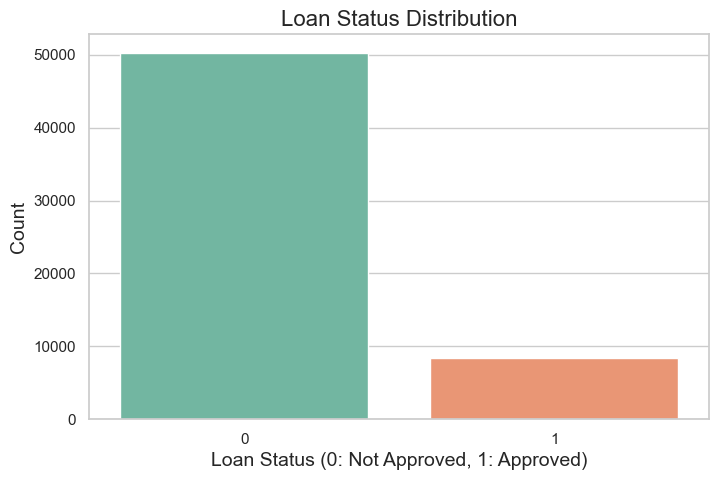

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Visualize target class imbalance
plt.figure(figsize=(8, 5))
sns.countplot(x="loan_status", data=df_train, palette="Set2")
plt.title("Loan Status Distribution", fontsize=16)
plt.xlabel("Loan Status (0: Not Approved, 1: Approved)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()


#### Identify categorical and numerical features
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


## 4. Numerical Feature Distributions

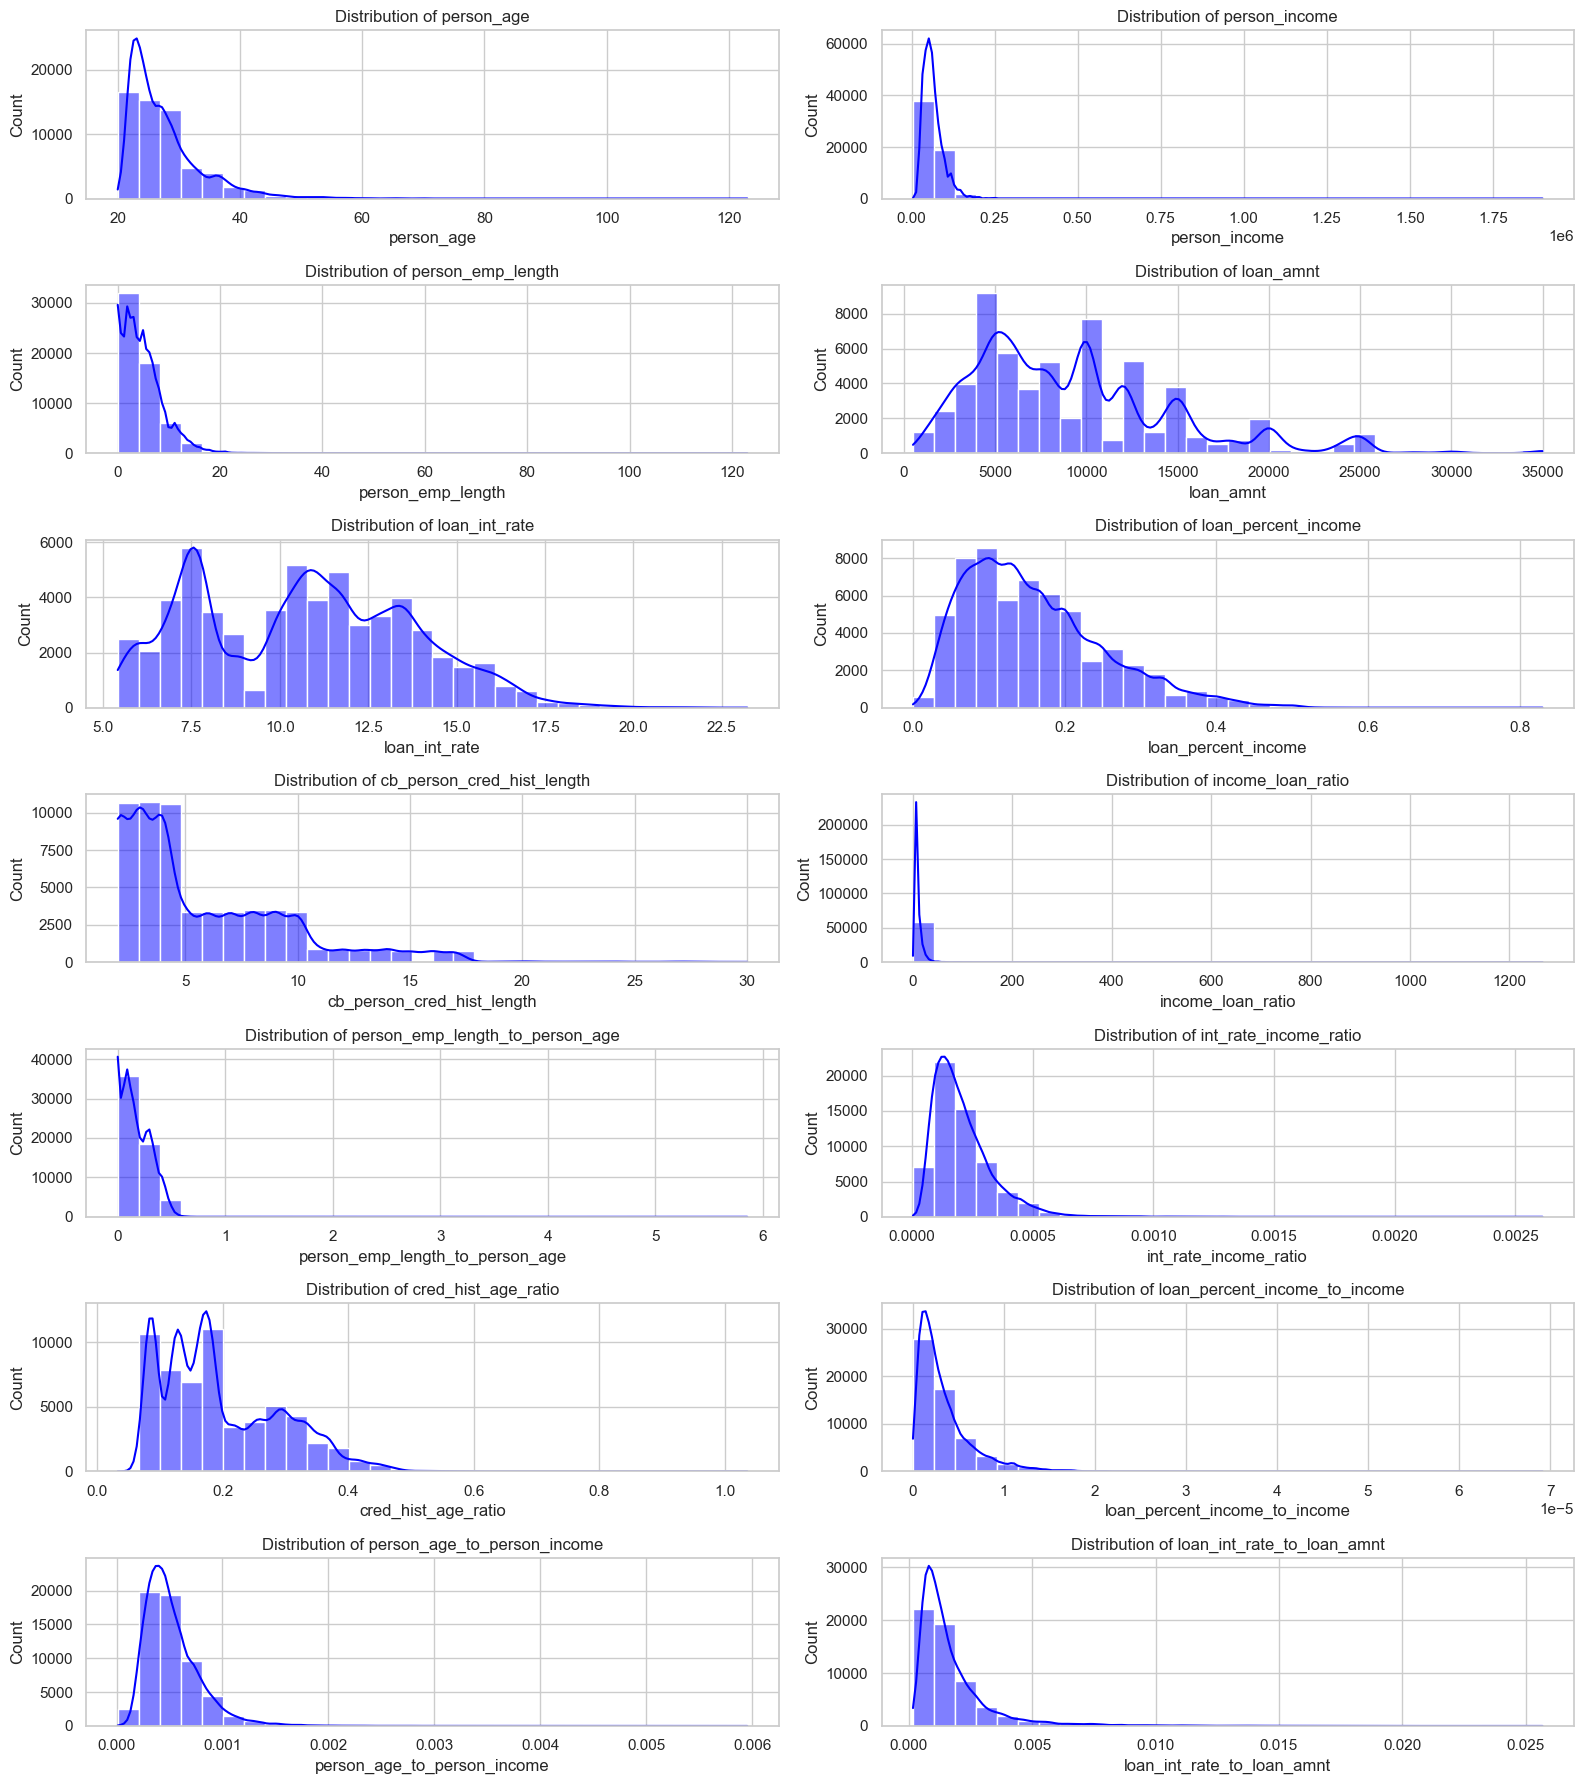

In [170]:
#numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(16, 18))
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.histplot(df_train[col], bins=30, kde=True, ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

## 5. Categorical Feature Distributions

C:\Users\monas\AppData\Local\Temp\ipykernel_24148\3332000594.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, palette="viridis", ax=axes[i])
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\3332000594.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, palette="viridis", ax=axes[i])
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\3332000594.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_trai

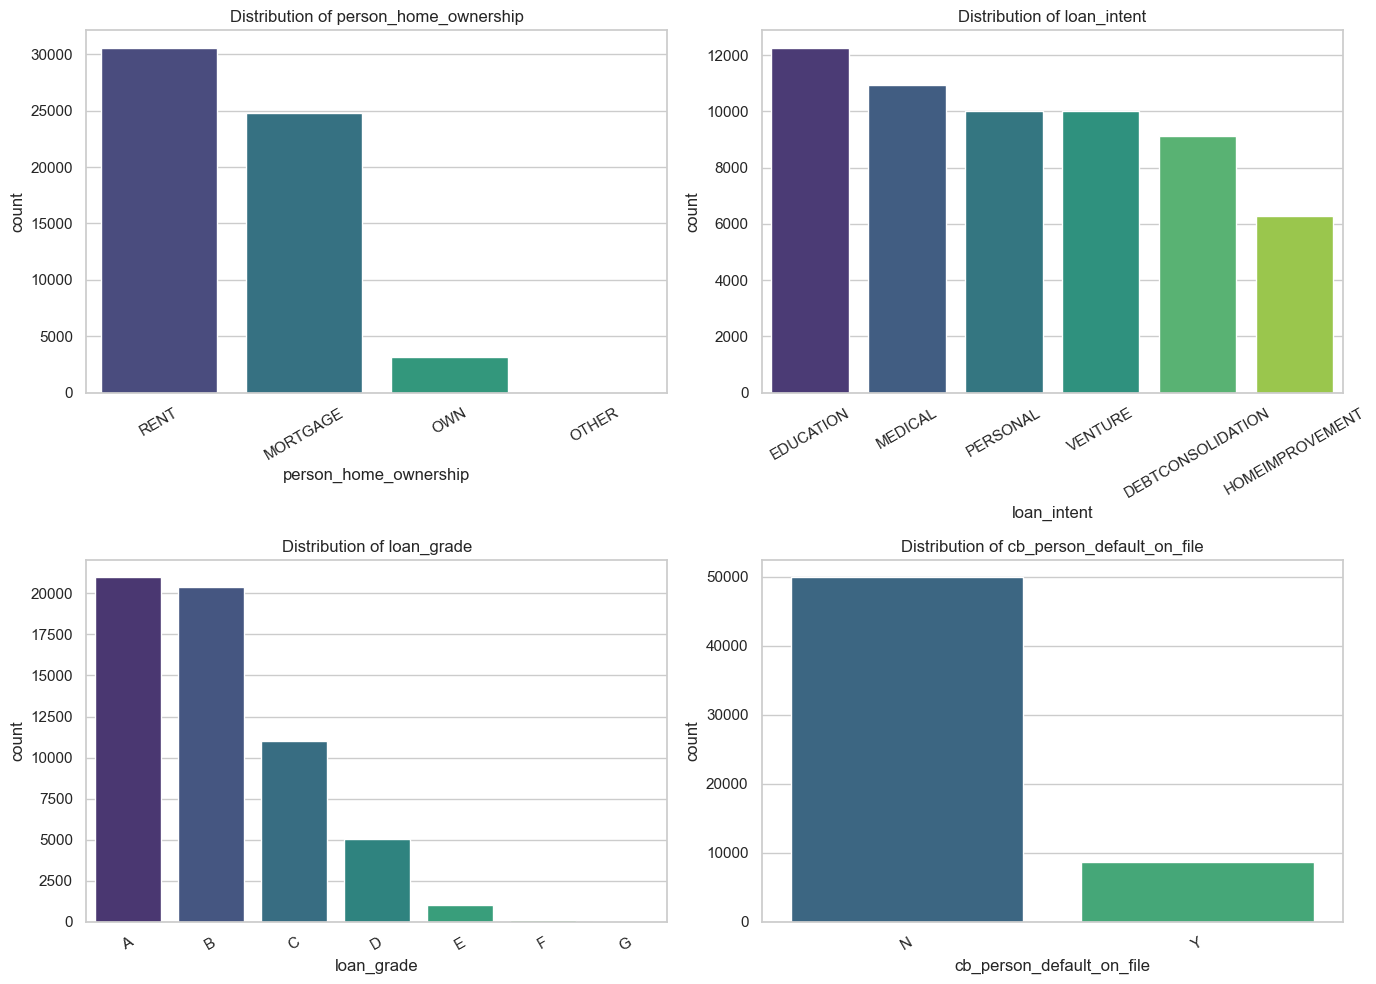

In [172]:
# 5. Categorical Feature Distributions
#categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()
for i, col in enumerate(categorical_features):
    sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, palette="viridis", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

## 6. Bivariate Analysis (Loan Status vs Categorical Features)

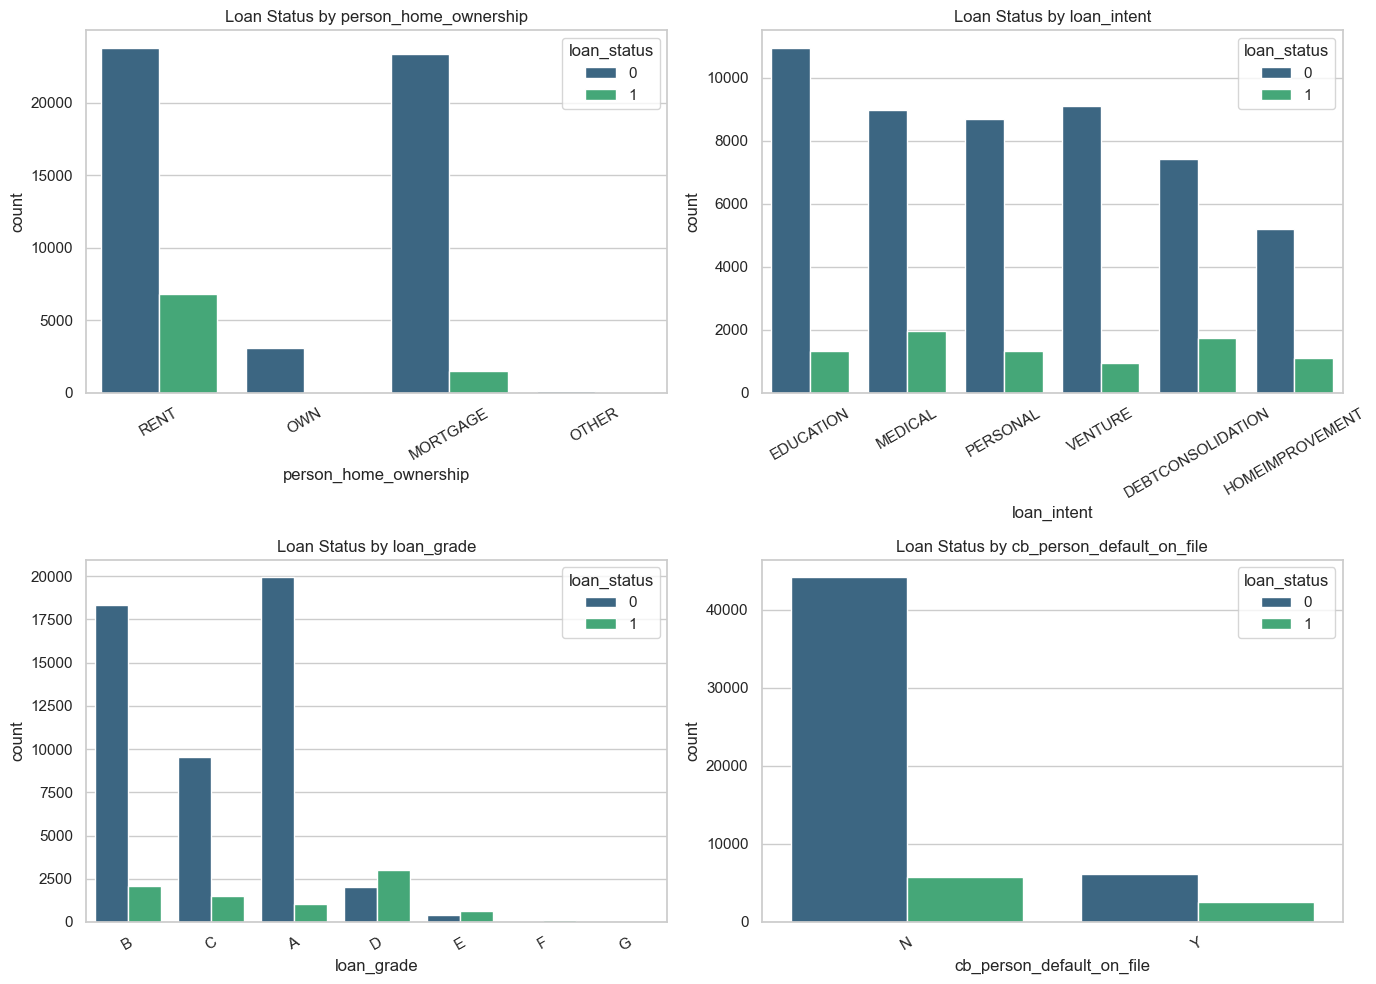

In [174]:
# 6. Bivariate Analysis (Loan Status vs Categorical Features)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()
plt.title("Bivariate Analysis - Loan Status vs Categorical Features")
for i, col in enumerate(categorical_features):
    sns.countplot(data=df_train, x=col, hue="loan_status", palette="viridis", ax=axes[i])
    axes[i].set_title(f"Loan Status by {col}")
    axes[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
#plt.title("Bivariate Analysis - Loan Status vs Categorical Features")
plt.show()

# Correlation Heatmap

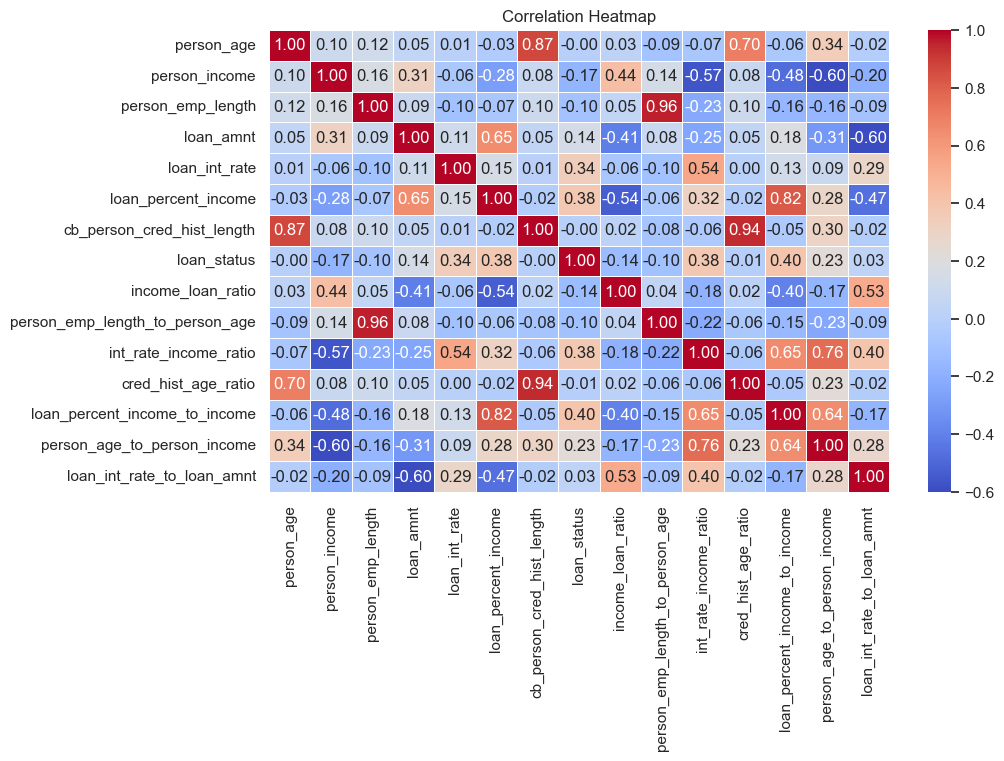

In [176]:
# 7. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Outlier Detection & Handling

In [178]:
## Train Set Outlier Detection

In [179]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.550857,6.033216,20.000000,23.000000,26.000000,30.000000,1.230000e+02
person_income,58645.0,64046.172871,37931.106979,4200.000000,42000.000000,58000.000000,75600.000000,1.900000e+06
person_emp_length,58645.0,4.701015,3.959784,0.000000,2.000000,4.000000,7.000000,1.230000e+02
loan_amnt,58645.0,9217.556518,5563.807384,500.000000,5000.000000,8000.000000,12000.000000,3.500000e+04
loan_int_rate,58645.0,10.677874,3.034697,5.420000,7.880000,10.750000,12.990000,2.322000e+01
loan_percent_income,58645.0,0.159238,0.091692,0.000000,0.090000,0.140000,0.210000,8.300000e-01
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.000000,3.000000,4.000000,8.000000,3.000000e+01
loan_status,58645.0,0.142382,0.349445,0.000000,0.000000,0.000000,0.000000,1.000000e+00
income_loan_ratio,58645.0,9.467154,10.191298,0.320000,4.777778,7.028571,11.200000,1.266667e+03
person_emp_length_to_person_age,58645.0,0.173368,0.137427,0.000000,0.064516,0.142857,0.272727,5.857143e+00


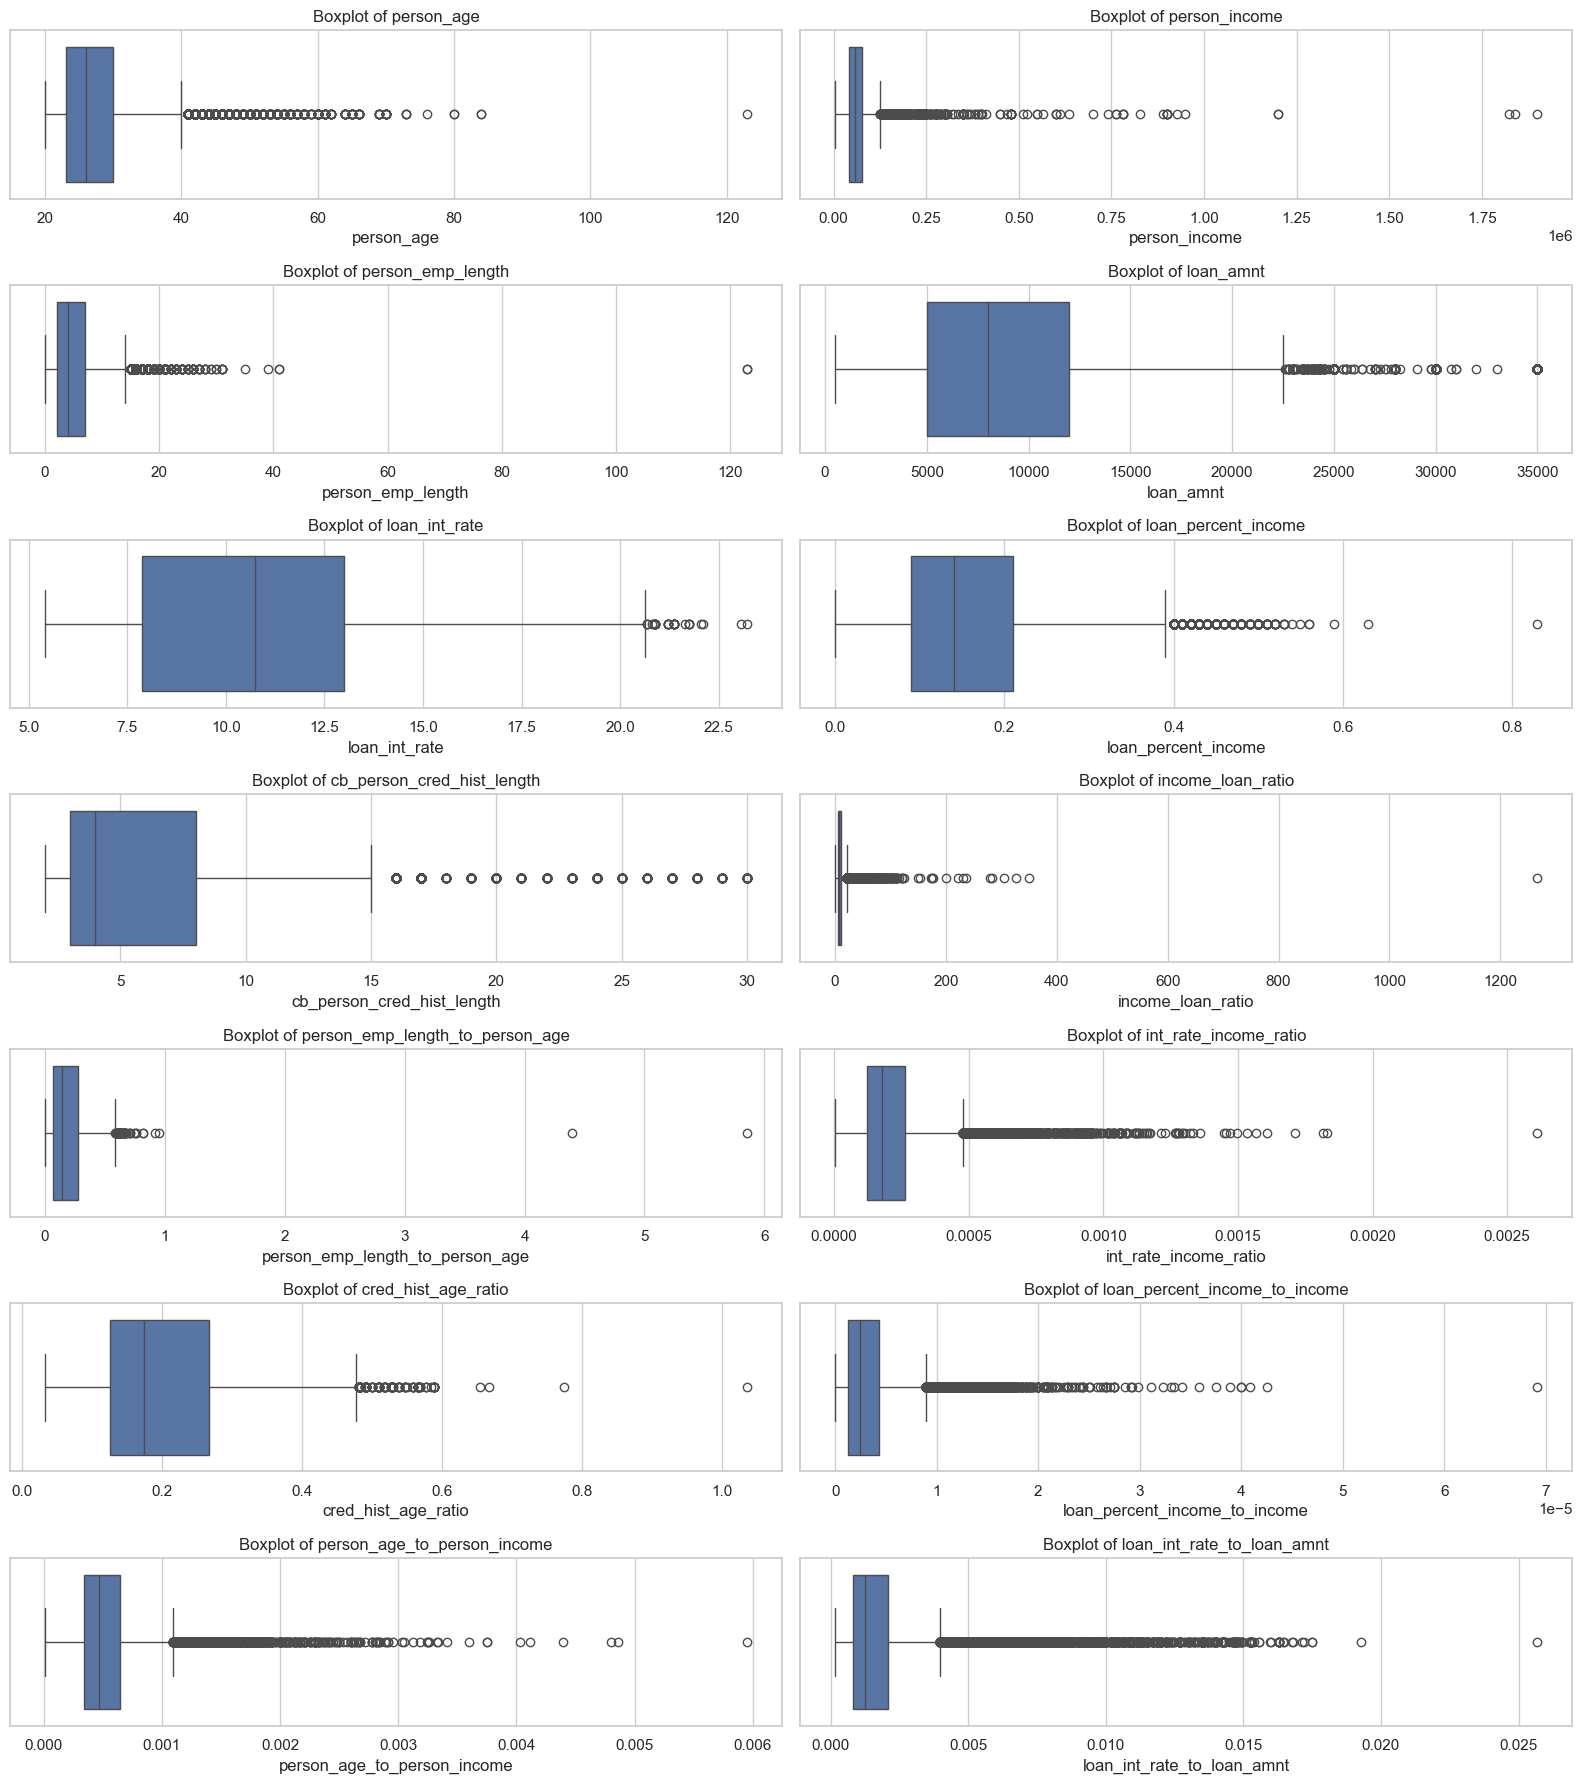

In [180]:
# 8. Outlier Detection - Boxplots - Train Set
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(16, 18))
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.boxplot(data=df_train, x=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [181]:
df_train.to_csv('final_df_train.csv')
df_test.to_csv('final_df_test.csv')

## Test Set Outlier Detection

In [183]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,39098.0,27.566781,6.032761,20.000000,23.000000,26.000000,30.000000,9.400000e+01
person_income,39098.0,64060.460842,37955.828705,4000.000000,42000.000000,58000.000000,75885.000000,1.900000e+06
person_emp_length,39098.0,4.687068,3.868395,0.000000,2.000000,4.000000,7.000000,4.200000e+01
loan_amnt,39098.0,9251.466188,5576.254680,700.000000,5000.000000,8000.000000,12000.000000,3.500000e+04
loan_int_rate,39098.0,10.661216,3.020220,5.420000,7.880000,10.750000,12.990000,2.211000e+01
loan_percent_income,39098.0,0.159573,0.091633,0.000000,0.090000,0.140000,0.210000,7.300000e-01
cb_person_cred_hist_length,39098.0,5.830707,4.072157,2.000000,3.000000,4.000000,8.000000,3.000000e+01
income_loan_ratio,39098.0,9.451315,11.166661,0.320000,4.800000,7.000000,11.000000,1.266667e+03
person_emp_length_to_person_age,39098.0,0.172908,0.133990,0.000000,0.064516,0.142857,0.272727,9.393939e-01
int_rate_income_ratio,39098.0,0.000208,0.000126,0.000003,0.000121,0.000179,0.000264,3.211905e-03


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2763403718.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x=col, palette ='husl', ax=axes[i])
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2763403718.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x=col, palette ='husl', ax=axes[i])
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2763403718.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x=col, palette ='husl', ax=axes[i])
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\27634037

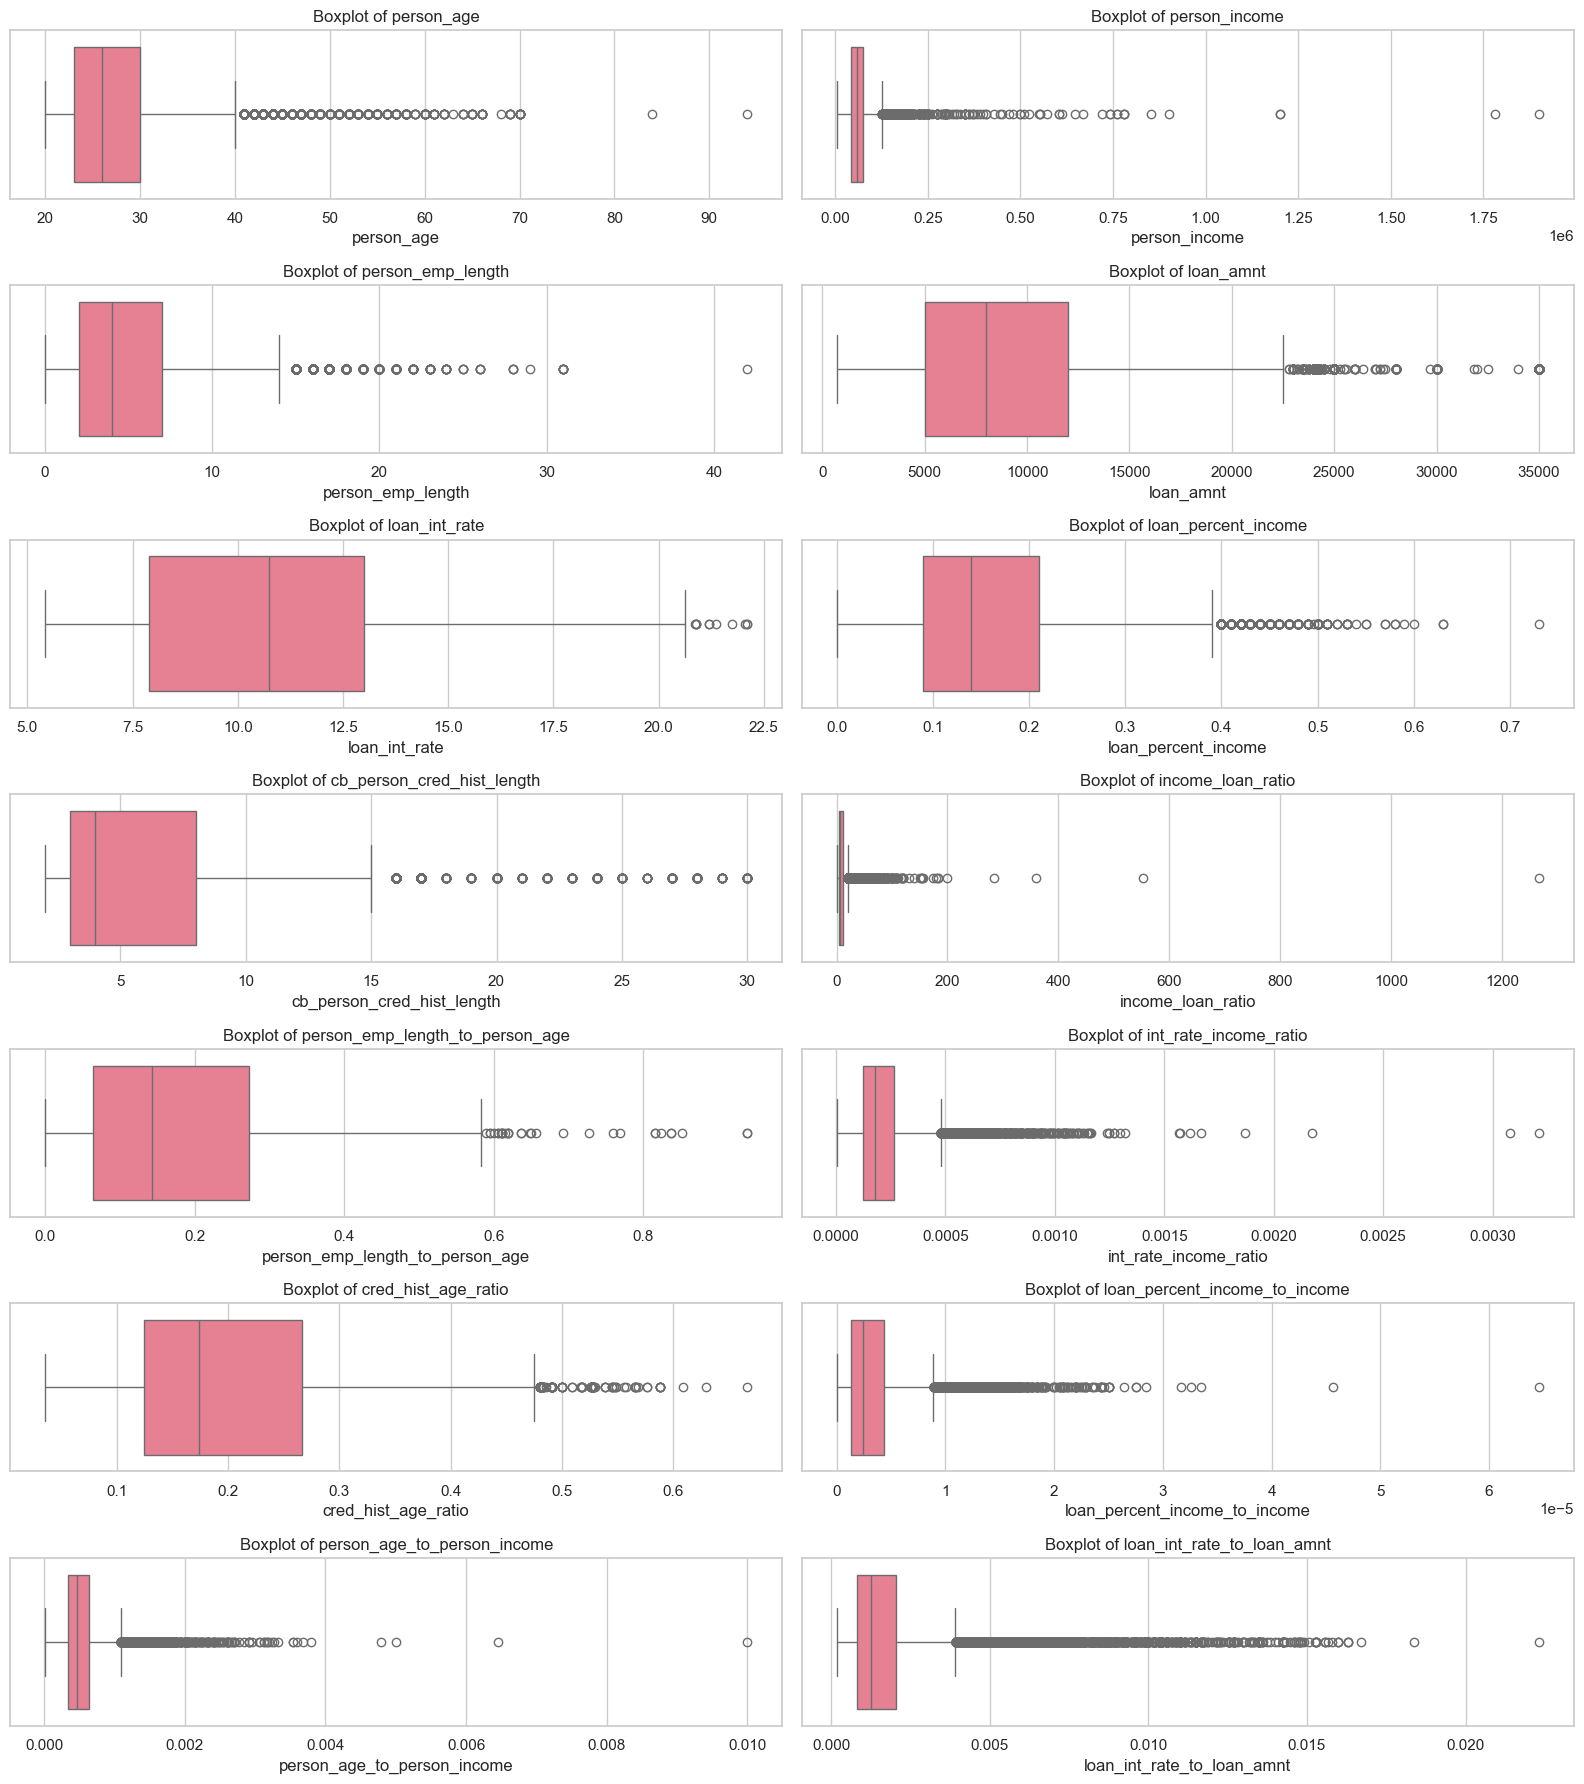

In [184]:
# 8. Outlier Detection - Boxplots - Test Set
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(16, 18))
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.boxplot(data=df_test, x=col, palette ='husl', ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

## Outlier Handling

In [186]:
# Use train-based thresholds for both
def get_outlier_bounds(df, columns, lower=0.01, upper=0.99):
    bounds = {}
    for col in columns:
        lower_bound = df[col].quantile(lower)
        upper_bound = df[col].quantile(upper)
        bounds[col] = (lower_bound, upper_bound)
    return bounds

#def apply_outlier_capping(df, bounds_dict):
#    for col, (low, high) in bounds_dict.items():
#        df[col] = df[col].clip(low, high)
#    return df

def apply_outlier_capping(df, bounds_dict):
    for col, (low, high) in bounds_dict.items():
        df[col] = df[col].clip(lower=low, upper=high)
    return df.infer_objects(copy=False)

# Step 1: Calculate from train set
outlier_bounds = get_outlier_bounds(df_train, numerical_features)

# Step 2: Apply to both sets
df_train = apply_outlier_capping(df_train, outlier_bounds)
df_test = apply_outlier_capping(df_test, outlier_bounds)


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4061384027.py:17: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].clip(lower=low, upper=high)
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4061384027.py:17: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].clip

In [187]:
# Verify the changes of Train Set
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.487902,5.736368,2.100000e+01,23.000000,26.000000,30.000000,49.000000
person_income,58645.0,63288.311587,29593.505039,2.160000e+04,42000.000000,58000.000000,75600.000000,175000.000000
person_emp_length,58645.0,4.670816,3.792316,0.000000e+00,2.000000,4.000000,7.000000,17.000000
loan_amnt,58645.0,9179.714537,5415.293926,1.286000e+03,5000.000000,8000.000000,12000.000000,25000.000000
loan_int_rate,58645.0,10.667395,3.007559,5.420000e+00,7.880000,10.750000,12.990000,17.490000
loan_percent_income,58645.0,0.158925,0.090108,3.000000e-02,0.090000,0.140000,0.210000,0.420000
cb_person_cred_hist_length,58645.0,5.757626,3.807736,2.000000e+00,3.000000,4.000000,8.000000,17.000000
loan_status,58645.0,0.142382,0.349445,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income_loan_ratio,58645.0,9.230133,6.907357,2.343750e+00,4.777778,7.028571,11.200000,40.175880
person_emp_length_to_person_age,58645.0,0.172848,0.133266,0.000000e+00,0.064516,0.142857,0.272727,0.500000


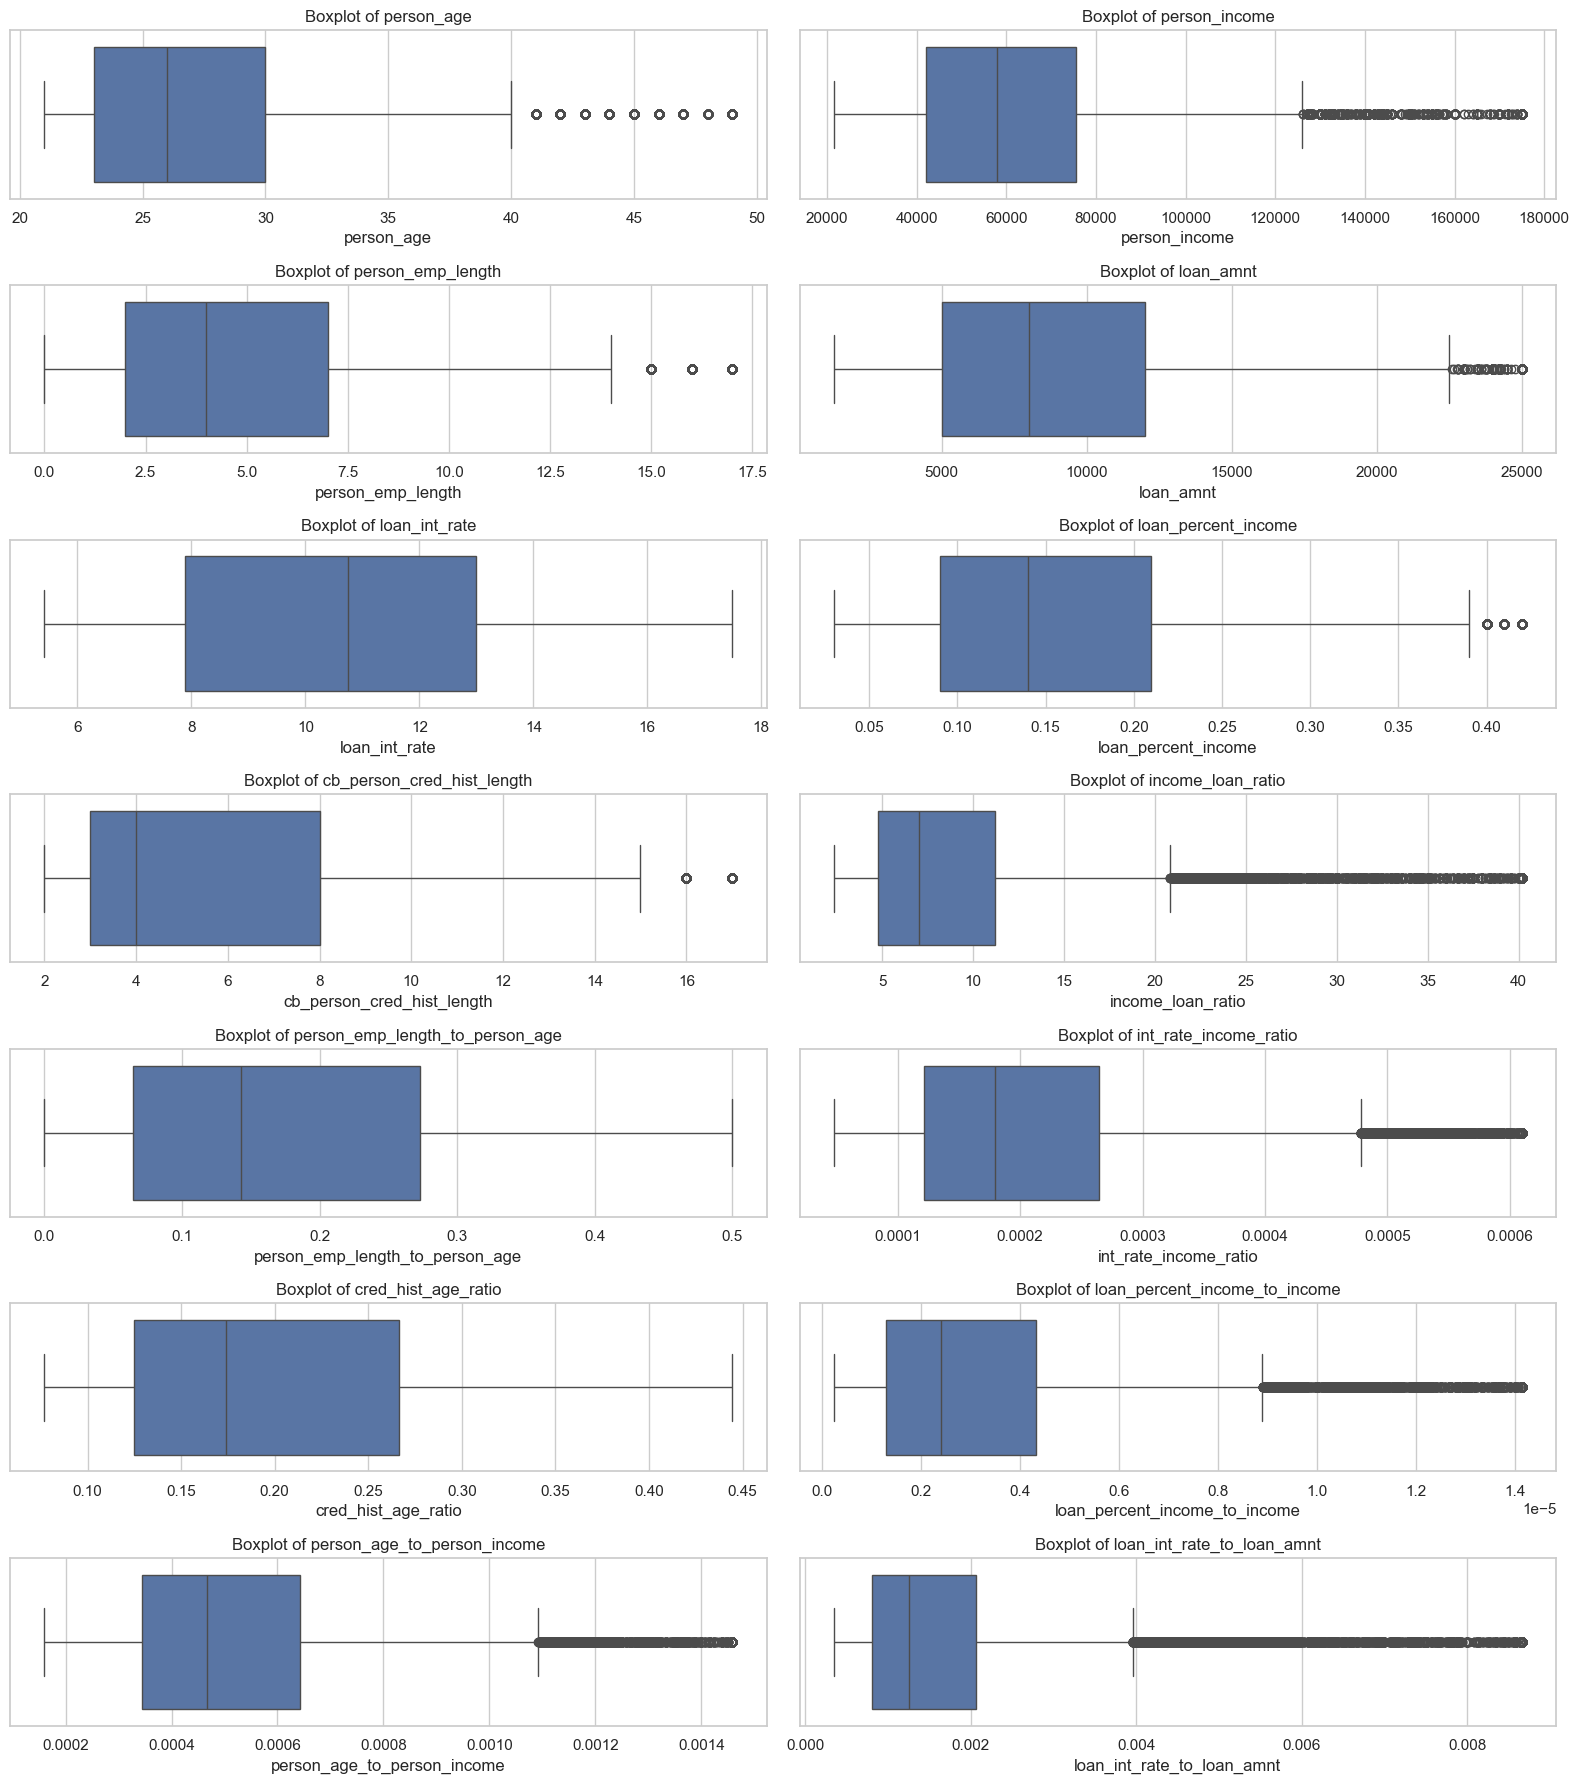

In [188]:
# Outlier Detection - Boxplots - Train Set
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(16, 18))
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.boxplot(data=df_train, x=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [189]:
# Verify the changes of Test Set
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,39098.0,27.501893,5.734191,2.100000e+01,23.000000,26.000000,30.000000,49.000000
person_income,39098.0,63272.126451,29353.906489,2.160000e+04,42000.000000,58000.000000,75885.000000,175000.000000
person_emp_length,39098.0,4.661645,3.767289,0.000000e+00,2.000000,4.000000,7.000000,17.000000
loan_amnt,39098.0,9210.295002,5416.066267,1.286000e+03,5000.000000,8000.000000,12000.000000,25000.000000
loan_int_rate,39098.0,10.651938,2.996423,5.420000e+00,7.880000,10.750000,12.990000,17.490000
loan_percent_income,39098.0,0.159233,0.089930,3.000000e-02,0.090000,0.140000,0.210000,0.420000
cb_person_cred_hist_length,39098.0,5.769912,3.832003,2.000000e+00,3.000000,4.000000,8.000000,17.000000
income_loan_ratio,39098.0,9.175618,6.862752,2.343750e+00,4.800000,7.000000,11.000000,40.175880
person_emp_length_to_person_age,39098.0,0.172511,0.132824,0.000000e+00,0.064516,0.142857,0.272727,0.500000
int_rate_income_ratio,39098.0,0.000207,0.000116,4.792000e-05,0.000121,0.000179,0.000264,0.000610


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4089574486.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x=col, palette ='husl', ax=axes[i])
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4089574486.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x=col, palette ='husl', ax=axes[i])
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4089574486.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x=col, palette ='husl', ax=axes[i])
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\40895744

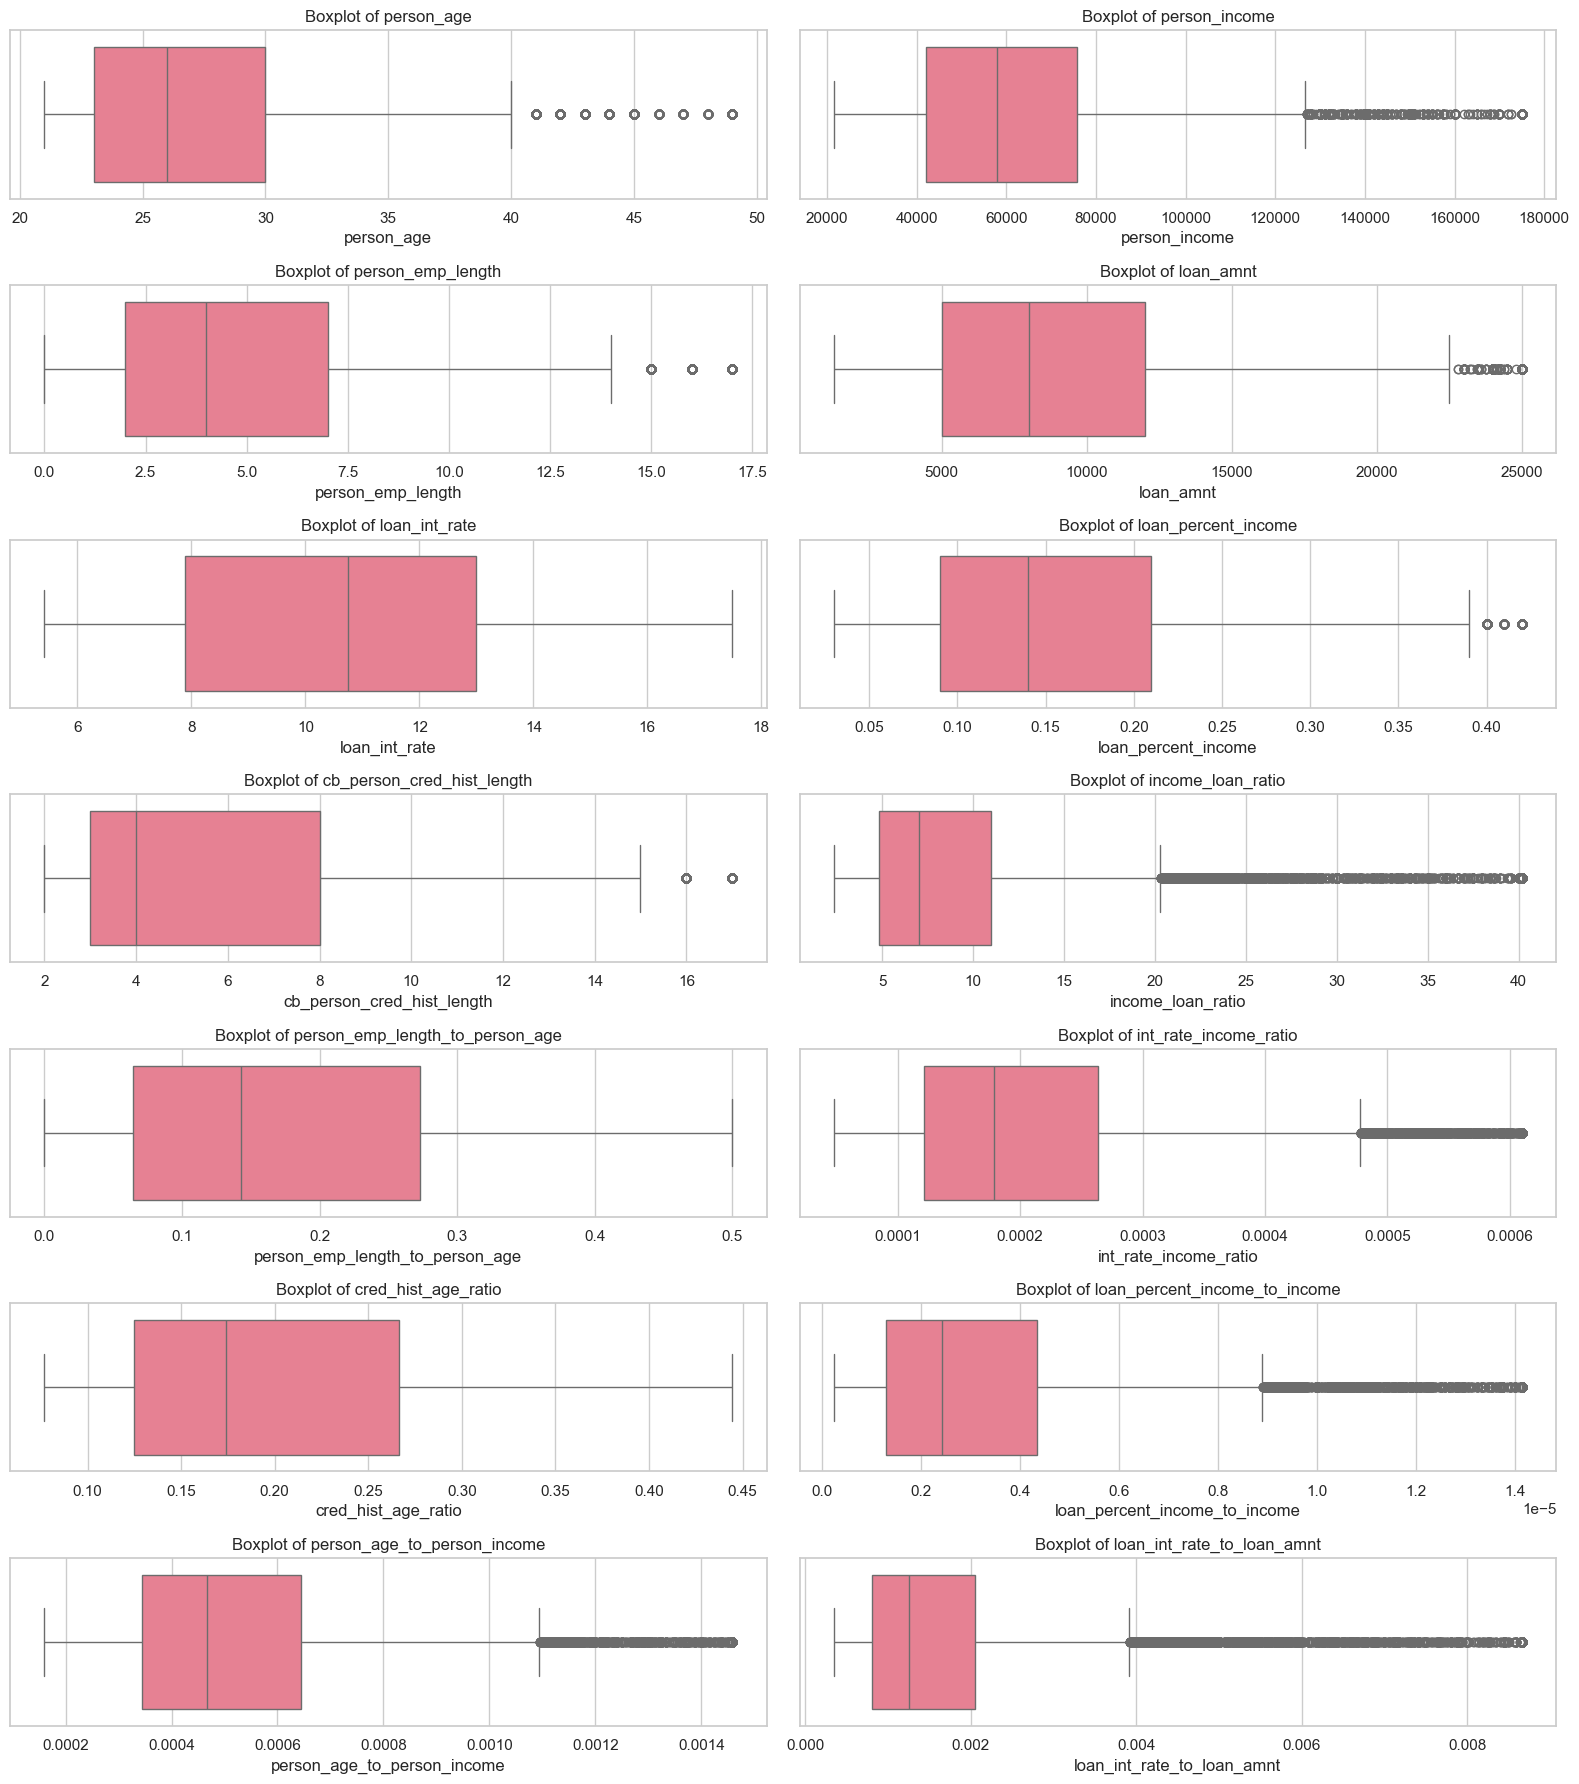

In [190]:
# Outlier Detection - Boxplots - Test Set
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(16, 18))
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.boxplot(data=df_test, x=col, palette ='husl', ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# Skewness Detection & Handling

In [192]:
print('Training Data shape before set_index :', df_train.shape)
print('Testing Data shape before set_index:', df_test.shape)

Training Data shape before set_index : (58645, 19)
Testing Data shape before set_index: (39098, 18)


## Skewness Detection

### Train Test Skewness

In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute skewness
def analyze_skewness(df, features):
    skewness_values = df[features].skew()
    
    # Categorizing Skewness Levels
    skewness_categories = pd.DataFrame({'Feature': features, 'Skewness': skewness_values})
    skewness_categories['Category'] = skewness_categories['Skewness'].apply(
        lambda x: "Highly Right-Skewed" if x > 1 else 
                  "Moderately Right-Skewed" if x > 0.5 else 
                  "Symmetric" if -0.5 <= x <= 0.5 else 
                  "Moderately Left-Skewed" if x < -0.5 else "Highly Left-Skewed"
    )
    
    return skewness_categories

# Compute skewness for df_train
train_skewness_df = analyze_skewness(df_train, numerical_features)
# Sort by Skewness (descending by default), reset index, and drop the old index
train_skewness_df = train_skewness_df.sort_values(by='Skewness', ascending=False).reset_index(drop=True)

# Display the sorted DataFrame
train_skewness_df

,Feature,Skewness,Category
0,loan_int_rate_to_loan_amnt,2.483412,Highly Right-Skewed
1,income_loan_ratio,2.151051,Highly Right-Skewed
2,loan_percent_income_to_income,1.649414,Highly Right-Skewed
3,person_age,1.498532,Highly Right-Skewed
4,person_income,1.296982,Highly Right-Skewed
5,person_age_to_person_income,1.260783,Highly Right-Skewed
6,cb_person_cred_hist_length,1.203652,Highly Right-Skewed
7,int_rate_income_ratio,1.199710,Highly Right-Skewed
8,loan_amnt,1.008329,Highly Right-Skewed
9,person_emp_length,0.957892,Moderately Right-Skewed


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\61854574.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=train_skewness_df_sorted['Feature'], x=train_skewness_df_sorted['Skewness'], palette=colors)


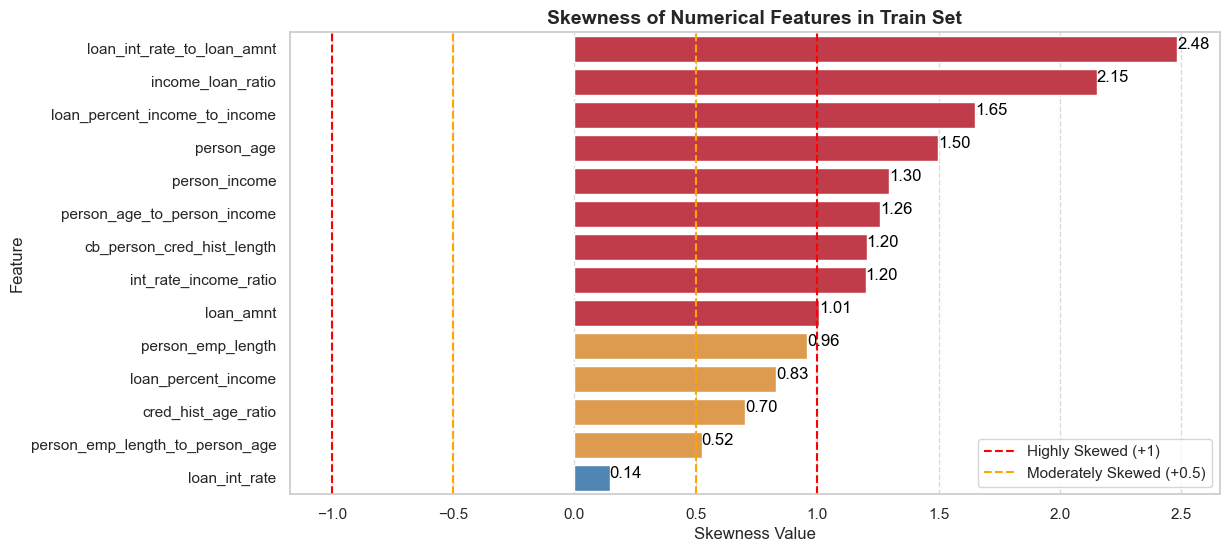

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort features by skewness for better visualization
train_skewness_df_sorted = train_skewness_df.sort_values(by="Skewness", ascending=False)

# Set figure size
plt.figure(figsize=(12, 6))

# Create a horizontal bar plot
colors = ["#D72638" if abs(x) > 1 else "#F49D37" if abs(x) > 0.5 else "#3F88C5" for x in train_skewness_df_sorted['Skewness']]
sns.barplot(y=train_skewness_df_sorted['Feature'], x=train_skewness_df_sorted['Skewness'], palette=colors)

# Add labels on bars
for index, value in enumerate(train_skewness_df_sorted['Skewness']):
    plt.text(value, index, f"{value:.2f}", color='black', ha="left" if value > 0 else "right", fontsize=12)

# Add threshold lines
plt.axvline(x=1, color='red', linestyle='--', label="Highly Skewed (+1)")
plt.axvline(x=-1, color='red', linestyle='--')
plt.axvline(x=0.5, color='orange', linestyle='--', label="Moderately Skewed (+0.5)")
plt.axvline(x=-0.5, color='orange', linestyle='--')

# Titles and labels
plt.title("Skewness of Numerical Features in Train Set", fontsize=14, fontweight="bold")
plt.xlabel("Skewness Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show plot
plt.show()


### Test Set Skewness

In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute skewness
def analyze_skewness(df, features):
    skewness_values = df[features].skew()
    
    # Categorizing Skewness Levels
    skewness_categories = pd.DataFrame({'Feature': features, 'Skewness': skewness_values})
    skewness_categories['Category'] = skewness_categories['Skewness'].apply(
        lambda x: "Highly Right-Skewed" if x > 1 else 
                  "Moderately Right-Skewed" if x > 0.5 else 
                  "Symmetric" if -0.5 <= x <= 0.5 else 
                  "Moderately Left-Skewed" if x < -0.5 else "Highly Left-Skewed"
    )
    
    return skewness_categories

# Compute skewness for df_train
test_skewness_df = analyze_skewness(df_test, numerical_features)
# Sort by Skewness (descending by default), reset index, and drop the old index
test_skewness_df = test_skewness_df.sort_values(by='Skewness', ascending=False).reset_index(drop=True)

# Display the sorted DataFrame
test_skewness_df

,Feature,Skewness,Category
0,loan_int_rate_to_loan_amnt,2.488009,Highly Right-Skewed
1,income_loan_ratio,2.185913,Highly Right-Skewed
2,loan_percent_income_to_income,1.635972,Highly Right-Skewed
3,person_age,1.509750,Highly Right-Skewed
4,person_income,1.287405,Highly Right-Skewed
5,person_age_to_person_income,1.260320,Highly Right-Skewed
6,cb_person_cred_hist_length,1.213889,Highly Right-Skewed
7,int_rate_income_ratio,1.210804,Highly Right-Skewed
8,loan_amnt,1.008520,Highly Right-Skewed
9,person_emp_length,0.937329,Moderately Right-Skewed


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\3466560574.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=test_skewness_df_sorted['Feature'], x=test_skewness_df_sorted['Skewness'], palette=colors)
C:\Users\monas\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


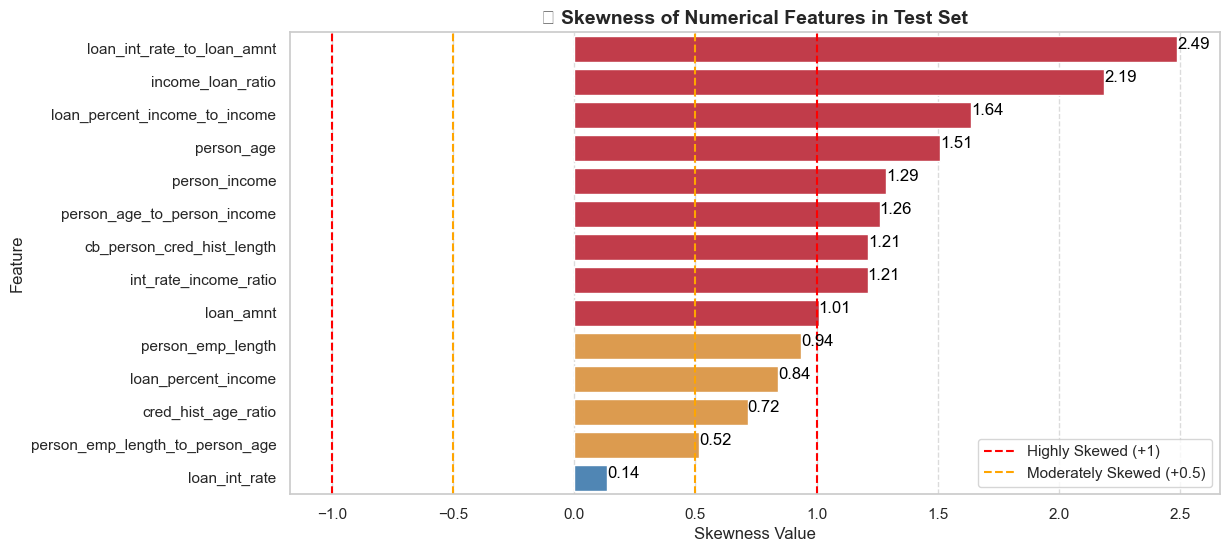

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort features by skewness for better visualization
test_skewness_df_sorted = test_skewness_df.sort_values(by="Skewness", ascending=False)

# Set figure size
plt.figure(figsize=(12, 6))

# Create a horizontal bar plot
colors = ["#D72638" if abs(x) > 1 else "#F49D37" if abs(x) > 0.5 else "#3F88C5" for x in test_skewness_df_sorted['Skewness']]
sns.barplot(y=test_skewness_df_sorted['Feature'], x=test_skewness_df_sorted['Skewness'], palette=colors)

# Add labels on bars
for index, value in enumerate(test_skewness_df_sorted['Skewness']):
    plt.text(value, index, f"{value:.2f}", color='black', ha="left" if value > 0 else "right", fontsize=12)

# Add threshold lines
plt.axvline(x=1, color='red', linestyle='--', label="Highly Skewed (+1)")
plt.axvline(x=-1, color='red', linestyle='--')
plt.axvline(x=0.5, color='orange', linestyle='--', label="Moderately Skewed (+0.5)")
plt.axvline(x=-0.5, color='orange', linestyle='--')

# Titles and labels
plt.title("📊 Skewness of Numerical Features in Test Set", fontsize=14, fontweight="bold")
plt.xlabel("Skewness Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [200]:
## Skewness Handling

In [201]:
from sklearn.preprocessing import PowerTransformer

# Identify skewed numeric features
#num_cols = df_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Step 1: Fit on train set
pt = PowerTransformer(method='yeo-johnson')
df_train[numerical_features] = pt.fit_transform(df_train[numerical_features])

# Step 2: Apply on test set using the same fitted transformer
df_test[numerical_features] = pt.transform(df_test[numerical_features])


In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute skewness
def analyze_skewness(df, features):
    skewness_values = df[features].skew()
    
    # Categorizing Skewness Levels
    skewness_categories = pd.DataFrame({'Feature': features, 'Skewness': skewness_values})
    skewness_categories['Category'] = skewness_categories['Skewness'].apply(
        lambda x: "Highly Right-Skewed" if x > 1 else 
                  "Moderately Right-Skewed" if x > 0.5 else 
                  "Symmetric" if -0.5 <= x <= 0.5 else 
                  "Moderately Left-Skewed" if x < -0.5 else "Highly Left-Skewed"
    )
    
    return skewness_categories

# Compute skewness for df_train
train_skewness_df = analyze_skewness(df_train, numerical_features)
# Sort by Skewness (descending by default), reset index, and drop the old index
train_skewness_df = train_skewness_df.sort_values(by='Skewness', ascending=False).reset_index(drop=True)

# Display the sorted DataFrame
train_skewness_df

,Feature,Skewness,Category
0,loan_int_rate_to_loan_amnt,0.352831,Symmetric
1,loan_percent_income_to_income,0.276379,Symmetric
2,person_age,0.164801,Symmetric
3,int_rate_income_ratio,0.138592,Symmetric
4,cred_hist_age_ratio,0.123332,Symmetric
5,person_age_to_person_income,0.108189,Symmetric
6,cb_person_cred_hist_length,0.090160,Symmetric
7,loan_percent_income,0.085971,Symmetric
8,person_emp_length_to_person_age,0.078011,Symmetric
9,income_loan_ratio,0.052639,Symmetric


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\61854574.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=train_skewness_df_sorted['Feature'], x=train_skewness_df_sorted['Skewness'], palette=colors)


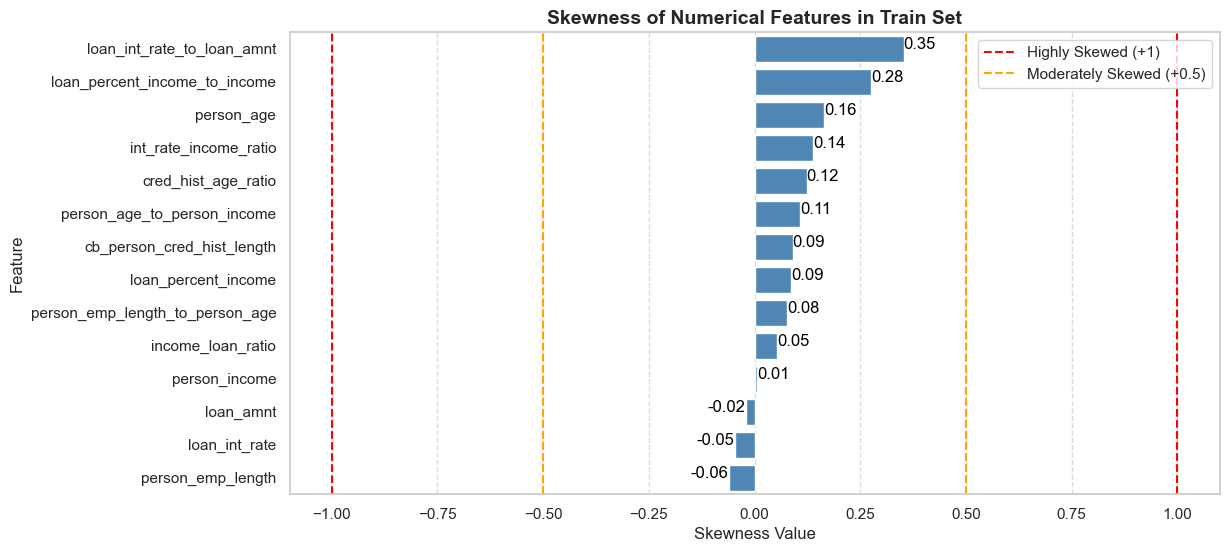

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort features by skewness for better visualization
train_skewness_df_sorted = train_skewness_df.sort_values(by="Skewness", ascending=False)

# Set figure size
plt.figure(figsize=(12, 6))

# Create a horizontal bar plot
colors = ["#D72638" if abs(x) > 1 else "#F49D37" if abs(x) > 0.5 else "#3F88C5" for x in train_skewness_df_sorted['Skewness']]
sns.barplot(y=train_skewness_df_sorted['Feature'], x=train_skewness_df_sorted['Skewness'], palette=colors)

# Add labels on bars
for index, value in enumerate(train_skewness_df_sorted['Skewness']):
    plt.text(value, index, f"{value:.2f}", color='black', ha="left" if value > 0 else "right", fontsize=12)

# Add threshold lines
plt.axvline(x=1, color='red', linestyle='--', label="Highly Skewed (+1)")
plt.axvline(x=-1, color='red', linestyle='--')
plt.axvline(x=0.5, color='orange', linestyle='--', label="Moderately Skewed (+0.5)")
plt.axvline(x=-0.5, color='orange', linestyle='--')

# Titles and labels
plt.title("Skewness of Numerical Features in Train Set", fontsize=14, fontweight="bold")
plt.xlabel("Skewness Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show plot
plt.show()


In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute skewness
def analyze_skewness(df, features):
    skewness_values = df[features].skew()
    
    # Categorizing Skewness Levels
    skewness_categories = pd.DataFrame({'Feature': features, 'Skewness': skewness_values})
    skewness_categories['Category'] = skewness_categories['Skewness'].apply(
        lambda x: "Highly Right-Skewed" if x > 1 else 
                  "Moderately Right-Skewed" if x > 0.5 else 
                  "Symmetric" if -0.5 <= x <= 0.5 else 
                  "Moderately Left-Skewed" if x < -0.5 else "Highly Left-Skewed"
    )
    
    return skewness_categories

# Compute skewness for df_train
test_skewness_df = analyze_skewness(df_test, numerical_features)
# Sort by Skewness (descending by default), reset index, and drop the old index
test_skewness_df = test_skewness_df.sort_values(by='Skewness', ascending=False).reset_index(drop=True)

# Display the sorted DataFrame
test_skewness_df

,Feature,Skewness,Category
0,loan_int_rate_to_loan_amnt,0.355956,Symmetric
1,loan_percent_income_to_income,0.266741,Symmetric
2,person_age,0.164017,Symmetric
3,int_rate_income_ratio,0.146301,Symmetric
4,cred_hist_age_ratio,0.129440,Symmetric
5,person_age_to_person_income,0.115661,Symmetric
6,cb_person_cred_hist_length,0.090747,Symmetric
7,loan_percent_income,0.087227,Symmetric
8,person_emp_length_to_person_age,0.072839,Symmetric
9,income_loan_ratio,0.053852,Symmetric


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\3466560574.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=test_skewness_df_sorted['Feature'], x=test_skewness_df_sorted['Skewness'], palette=colors)
C:\Users\monas\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


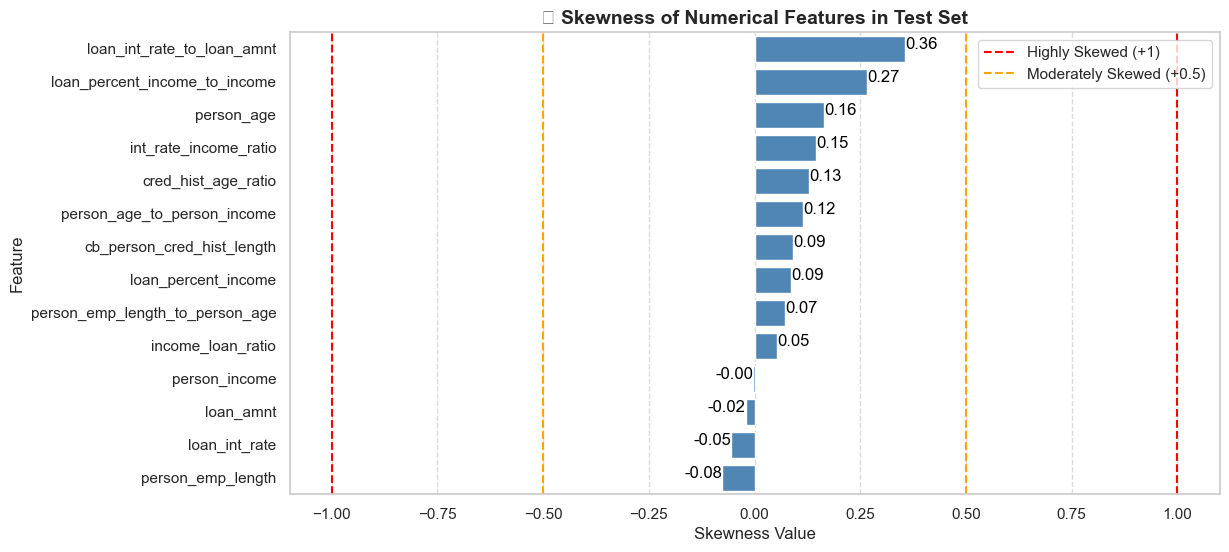

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort features by skewness for better visualization
test_skewness_df_sorted = test_skewness_df.sort_values(by="Skewness", ascending=False)

# Set figure size
plt.figure(figsize=(12, 6))

# Create a horizontal bar plot
colors = ["#D72638" if abs(x) > 1 else "#F49D37" if abs(x) > 0.5 else "#3F88C5" for x in test_skewness_df_sorted['Skewness']]
sns.barplot(y=test_skewness_df_sorted['Feature'], x=test_skewness_df_sorted['Skewness'], palette=colors)

# Add labels on bars
for index, value in enumerate(test_skewness_df_sorted['Skewness']):
    plt.text(value, index, f"{value:.2f}", color='black', ha="left" if value > 0 else "right", fontsize=12)

# Add threshold lines
plt.axvline(x=1, color='red', linestyle='--', label="Highly Skewed (+1)")
plt.axvline(x=-1, color='red', linestyle='--')
plt.axvline(x=0.5, color='orange', linestyle='--', label="Moderately Skewed (+0.5)")
plt.axvline(x=-0.5, color='orange', linestyle='--')

# Titles and labels
plt.title("📊 Skewness of Numerical Features in Test Set", fontsize=14, fontweight="bold")
plt.xlabel("Skewness Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show plot
plt.show()

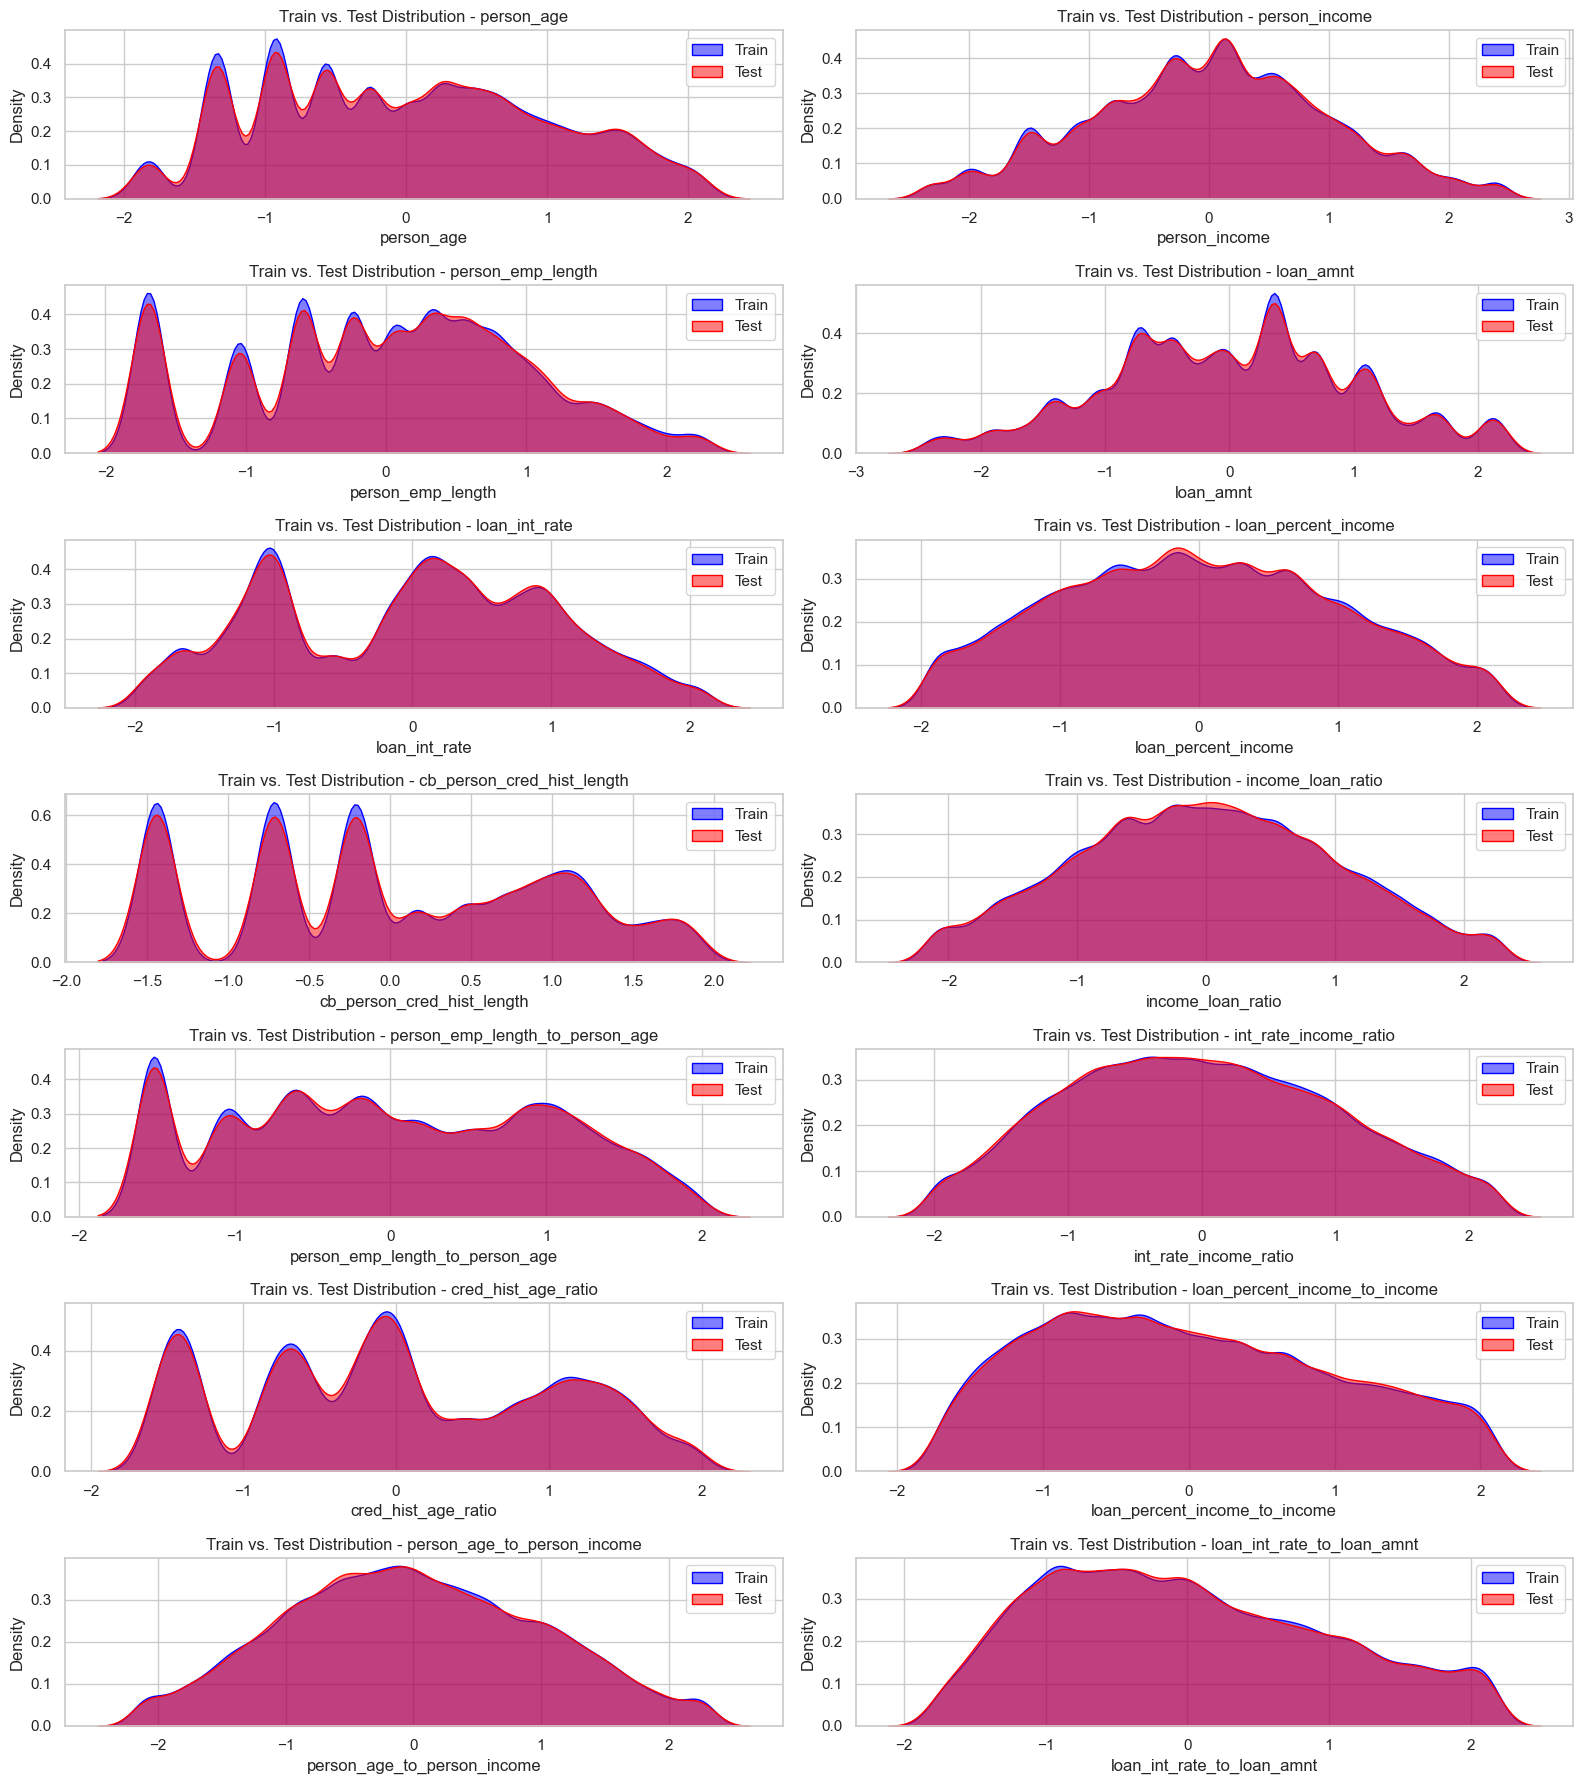

In [206]:
# 9. Train vs Test Feature Distribution Comparison
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(16, 18))
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.kdeplot(df_train[col], label="Train", fill=True, color="blue", alpha=0.5, ax=axes[i])
    sns.kdeplot(df_test[col], label="Test", fill=True, color="red", alpha=0.5, ax=axes[i])
    axes[i].set_title(f"Train vs. Test Distribution - {col}")
    axes[i].legend()
plt.tight_layout()
plt.show()

In [207]:
import pandas as pd
from scipy.stats import ks_2samp

# Function to compare train vs test distributions using KS test
def compare_train_test_distribution(df_train, df_test, numerical_features):
    results = []

    for col in numerical_features:
        # Perform Kolmogorov-Smirnov (KS) test
        ks_stat, p_value = ks_2samp(df_train[col].dropna(), df_test[col].dropna())

        # Interpret p-value: If p < 0.05, distributions are significantly different
        difference = "Significant Difference" if p_value < 0.05 else "Similar Distributions"

        # Store results
        results.append({
            "Feature": col,
            "Train Mean": df_train[col].mean(),
            "Test Mean": df_test[col].mean(),
            "Train Std": df_train[col].std(),
            "Test Std": df_test[col].std(),
            "KS Statistic": ks_stat,
            "P-Value": p_value,
            "Result": difference
        })

    return pd.DataFrame(results)

# Compare distributions and display the result
distribution_comparison = compare_train_test_distribution(df_train, df_test, numerical_features)

# Display the table
distribution_comparison


,Feature,Train Mean,Test Mean,Train Std,Test Std,KS Statistic,P-Value,Result
0,person_age,1.183252e-12,0.004577,1.000009,0.996199,0.005099,0.573501,Similar Distributions
1,person_income,-8.622350e-15,0.002686,1.000009,0.994071,0.005002,0.598216,Similar Distributions
2,person_emp_length,7.808761e-17,-0.001338,1.000009,0.998365,0.002934,0.987274,Similar Distributions
3,loan_amnt,6.824942e-16,0.006943,1.000009,0.997308,0.004315,0.773185,Similar Distributions
4,loan_int_rate,7.269599e-19,-0.004813,1.000009,0.997331,0.004311,0.774117,Similar Distributions
5,loan_percent_income,2.650980e-16,0.004983,1.000009,0.995266,0.006219,0.323010,Similar Distributions
6,cb_person_cred_hist_length,1.779840e-16,0.001080,1.000009,1.002340,0.002999,0.983819,Similar Distributions
7,income_loan_ratio,-4.052802e-17,-0.005815,1.000009,0.995170,0.006304,0.307451,Similar Distributions
8,person_emp_length_to_person_age,-3.586336e-17,-0.001883,1.000009,0.998605,0.002405,0.999193,Similar Distributions
9,int_rate_income_ratio,5.876259e-16,-0.004622,1.000009,0.998912,0.004548,0.715203,Similar Distributions


In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

In [209]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,income_loan_ratio,person_emp_length_to_person_age,int_rate_income_ratio,cred_hist_age_ratio,loan_percent_income_to_income,person_age_to_person_income,loan_int_rate_to_loan_amnt
id,,,,,,,,,,,,,,,,,,,
0,1.534128,-1.126477,RENT,-1.693382,EDUCATION,B,-0.458336,0.327571,0.320351,N,1.629639,0,-0.344665,-1.516378,1.179385,1.640541,0.926677,1.781977,0.611697
1,-1.340164,-0.028541,OWN,0.550649,MEDICAL,C,-1.039963,0.902104,-1.097122,N,-1.443249,0,1.040840,0.845969,0.529608,-1.323287,-0.855692,-0.443007,1.492338
2,0.628716,-1.599364,OWN,0.951790,PERSONAL,A,-0.458336,-0.543684,0.735059,N,1.198822,0,-0.700489,0.865016,1.059803,1.449072,1.490096,1.691127,0.161300
3,0.790040,0.472618,RENT,1.869895,VENTURE,B,0.686033,0.205401,0.320351,N,0.158575,0,-0.344665,1.813206,-0.287922,-0.152784,-0.093659,-0.243796,-0.619771
4,-1.340164,0.127765,RENT,-0.593408,MEDICAL,A,-0.458336,-1.284266,-0.602956,N,-0.716479,0,0.551815,-0.539630,-0.860544,-0.571972,-0.560800,-0.597512,-0.269638


In [210]:
import pickle
# Separate features and target
y = df_train["loan_status"]
X = df_train.drop(columns=["loan_status"])  # ["loan_status", "id"])

# Create Validation Set (80% Train, 20% Validation)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

# --- 2. Apply Target Encoding & Scaling ---
encoder = TargetEncoder()
scaler = StandardScaler()

# Encode categorical features BEFORE applying SMOTE
X_train_encoded = X_train.copy()
X_valid_encoded = X_valid.copy()
X_test_encoded = df_test.copy()

for cat in categorical_features:
    encoder.fit(X_train[cat], y_train)
    X_train_encoded[cat] = encoder.transform(X_train[cat])
    X_valid_encoded[cat] = encoder.transform(X_valid[cat])
    X_test_encoded[cat] = encoder.transform(X_test_encoded[cat])

to_scale_features = numerical_features + categorical_features  # Include encoded categorical features

# Apply SMOTE for Balancing
smote = SMOTE(random_state=7)
X_train_encoded, y_train = smote.fit_resample(X_train_encoded, y_train)

# Scale numerical features AFTER SMOTE
X_train_encoded[to_scale_features] = scaler.fit_transform(X_train_encoded[to_scale_features])
X_valid_encoded[to_scale_features] = scaler.transform(X_valid_encoded[to_scale_features])
X_test_encoded[to_scale_features] = scaler.transform(X_test_encoded[to_scale_features])


# Save the trained TargetEncoder object
with open('NEW_target_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

print("Target Encoder saved as 'NEW_target_encoder.pkl'")

# Save the scaler object
with open('NEW_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler saved as 'NEW_scaler.pkl'")


Target Encoder saved as 'NEW_target_encoder.pkl'
Scaler saved as 'NEW_scaler.pkl'


In [211]:
y_train

0        0
1        1
2        1
3        0
4        0
        ..
80467    1
80468    1
80469    1
80470    1
80471    1
Name: loan_status, Length: 80472, dtype: int64

In [212]:
X_train_encoded.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,income_loan_ratio,person_emp_length_to_person_age,int_rate_income_ratio,cred_hist_age_ratio,loan_percent_income_to_income,person_age_to_person_income,loan_int_rate_to_loan_amnt
0,0.025868,0.952460,-1.341494,-0.123262,1.240207,-0.785331,0.220278,-1.714657,-0.457824,-0.568096,-0.693786,0.445574,-0.203614,-1.677652,-0.879838,-0.848773,-1.029471,-1.096796
1,1.300390,-1.250091,0.761746,0.176039,0.988476,-0.785331,0.220278,-0.839514,1.192678,-0.568096,0.471065,-1.174294,-0.183421,0.597752,-0.009457,1.436885,1.665434,-0.674821
2,-1.320853,-0.113019,0.761746,-1.583759,-1.487227,-0.375822,1.476675,0.266787,1.566095,2.029655,-1.418918,-1.566369,-1.412639,0.294112,-1.304827,1.213288,-0.339922,-1.160617
3,-0.242356,1.400376,-1.914586,-0.123262,-1.487227,-0.548342,0.220278,-0.488067,-0.850025,-0.568096,-0.193376,0.751299,-0.162544,-1.366767,-0.220639,-1.270137,-1.526876,-0.508258
4,-1.320853,-0.878441,-1.341494,0.668279,-1.133189,-0.785331,-1.498727,-1.916654,-0.993071,-0.568096,-0.693786,1.020937,0.964489,-0.490737,-0.552830,-0.342597,0.429399,0.661230


LR: Mean AUC = 0.9077, Std AUC = 0.0008
LDA: Mean AUC = 0.9054, Std AUC = 0.0008
KNN: Mean AUC = 0.9754, Std AUC = 0.0007
DCT: Mean AUC = 0.9439, Std AUC = 0.0010
NB: Mean AUC = 0.8963, Std AUC = 0.0012


C:\Users\monas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\monas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\monas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\monas\anaconda3\Lib\site-packages\

XGB: Mean AUC = 0.9923, Std AUC = 0.0005
RF: Mean AUC = 0.9923, Std AUC = 0.0008
CB: Mean AUC = 0.9925, Std AUC = 0.0005
LGBM: Mean AUC = 0.9918, Std AUC = 0.0004
EXTREE: Mean AUC = 0.9954, Std AUC = 0.0005
        Mean AUC   Std AUC
EXTREE  0.995378  0.000464
CB      0.992464  0.000493
RF      0.992332  0.000830
XGB     0.992309  0.000494
LGBM    0.991777  0.000448
KNN     0.975386  0.000738
DCT     0.943943  0.001043
LR      0.907695  0.000821
LDA     0.905400  0.000845
NB      0.896317  0.001218
LR: Accuracy = 0.8451, ROC AUC = 0.8956
LDA: Accuracy = 0.8384, ROC AUC = 0.8928
KNN: Accuracy = 0.8632, ROC AUC = 0.8672
DCT: Accuracy = 0.9105, ROC AUC = 0.8354
NB: Accuracy = 0.7920, ROC AUC = 0.8853


C:\Users\monas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB: Accuracy = 0.9521, ROC AUC = 0.9517
RF: Accuracy = 0.9496, ROC AUC = 0.9331
CB: Accuracy = 0.9522, ROC AUC = 0.9546
LGBM: Accuracy = 0.9525, ROC AUC = 0.9557
EXTREE: Accuracy = 0.9425, ROC AUC = 0.9236
        Accuracy   ROC AUC
LGBM    0.952511  0.955674
CB      0.952170  0.954566
XGB     0.952085  0.951656
RF      0.949612  0.933071
EXTREE  0.942450  0.923632
LR      0.845085  0.895572
LDA     0.838435  0.892771
NB      0.791969  0.885324
KNN     0.863160  0.867168
DCT     0.910478  0.835445
LR: Accuracy (Train) = 0.8402, ROC AUC (Train) = 0.9078
LDA: Accuracy (Train) = 0.8364, ROC AUC (Train) = 0.9055
KNN: Accuracy (Train) = 0.9562, ROC AUC (Train) = 0.9971
DCT: Accuracy (Train) = 1.0000, ROC AUC (Train) = 1.0000
NB: Accuracy (Train) = 0.8186, ROC AUC (Train) = 0.8963


C:\Users\monas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB: Accuracy (Train) = 0.9795, ROC AUC (Train) = 0.9979
RF: Accuracy (Train) = 1.0000, ROC AUC (Train) = 1.0000
CB: Accuracy (Train) = 0.9770, ROC AUC (Train) = 0.9968
LGBM: Accuracy (Train) = 0.9701, ROC AUC (Train) = 0.9945
EXTREE: Accuracy (Train) = 1.0000, ROC AUC (Train) = 1.0000
        Accuracy   ROC AUC
DCT     1.000000  1.000000
RF      1.000000  1.000000
EXTREE  1.000000  1.000000
XGB     0.979521  0.997928
KNN     0.956208  0.997101
CB      0.977048  0.996789
LGBM    0.970139  0.994545
LR      0.840205  0.907821
LDA     0.836415  0.905524
NB      0.818633  0.896348
        Mean AUC   Std AUC  Validation AUC
EXTREE  0.995378  0.000464        0.923632
CB      0.992464  0.000493        0.954566
RF      0.992332  0.000830        0.933071
XGB     0.992309  0.000494        0.951656
LGBM    0.991777  0.000448        0.955674
KNN     0.975386  0.000738        0.867168
DCT     0.943943  0.001043        0.835445
LR      0.907695  0.000821        0.895572
LDA     0.905400  0.000845   

<Figure size 1200x600 with 0 Axes>

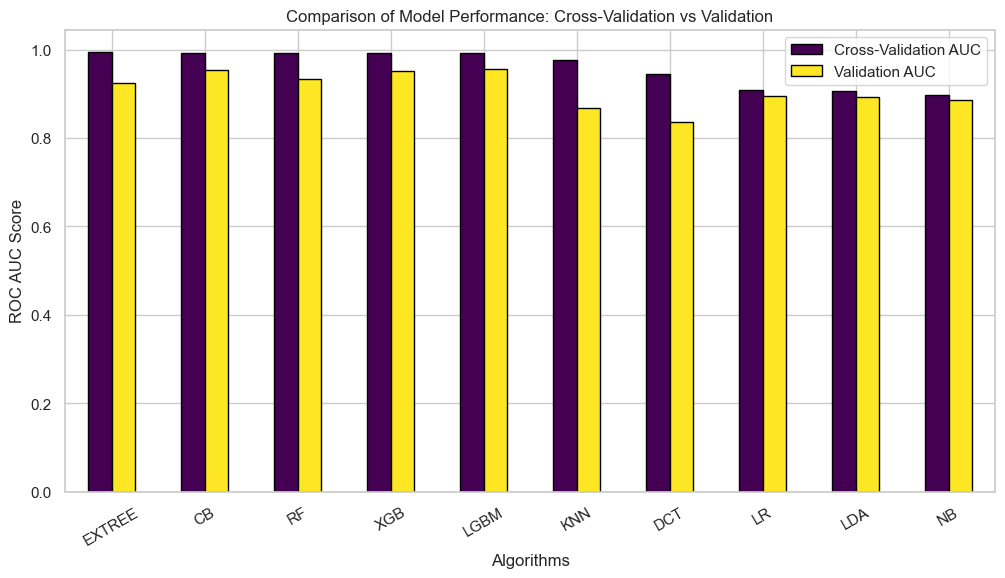

In [213]:
# --- 3. Baseline Model Training & Cross-Validation ---
models = [
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('DCT', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('RF', RandomForestClassifier(n_estimators=200)),
    ('CB', CatBoostClassifier(verbose=False)),
    ('LGBM', LGBMClassifier(verbosity=-1)),
    ('EXTREE', ExtraTreesClassifier(verbose=False))
    #('SVM', SVC(probability=True))
]

scoring = "roc_auc"
results = []
names = []
model_scores = {}

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    cv_results = cross_val_score(model, X_train_encoded, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    model_scores[name] = {"Mean AUC": cv_results.mean(), "Std AUC": cv_results.std()}
    print(f"{name}: Mean AUC = {cv_results.mean():.4f}, Std AUC = {cv_results.std():.4f}")

# Convert to DataFrame
model_results_df = pd.DataFrame(model_scores).T.sort_values(by="Mean AUC", ascending=False)
print(model_results_df)

# --- 4. Train Models on Training Data and Evaluate on Validation Set ---
validation_results = {}

for name, model in models:
    model.fit(X_train_encoded, y_train)  # Train
    y_pred_proba = model.predict_proba(X_valid_encoded)[:, 1] if hasattr(model, "predict_proba") else None
    auc = roc_auc_score(y_valid, y_pred_proba) if y_pred_proba is not None else None
    acc = accuracy_score(y_valid, model.predict(X_valid_encoded))

    validation_results[name] = {"Accuracy": acc, "ROC AUC": auc if auc else "N/A"}
    print(f"{name}: Accuracy = {acc:.4f}, ROC AUC = {auc:.4f}" if auc else f"{name}: Accuracy = {acc:.4f}")

# Convert to DataFrame
validation_results_df = pd.DataFrame(validation_results).T.sort_values(by="ROC AUC", ascending=False)
print(validation_results_df)

# --- 5. Train Models and Evaluate on Training Set ---
training_results = {}

for name, model in models:
    model.fit(X_train_encoded, y_train)
    y_pred_proba_train = model.predict_proba(X_train_encoded)[:, 1] if hasattr(model, "predict_proba") else None
    auc_train = roc_auc_score(y_train, y_pred_proba_train) if y_pred_proba_train is not None else None
    acc_train = accuracy_score(y_train, model.predict(X_train_encoded))

    training_results[name] = {"Accuracy": acc_train, "ROC AUC": auc_train if auc_train else "N/A"}
    print(f"{name}: Accuracy (Train) = {acc_train:.4f}, ROC AUC (Train) = {auc_train:.4f}")

# Convert to DataFrame
training_results_df = pd.DataFrame(training_results).T.sort_values(by="ROC AUC", ascending=False)
print(training_results_df)


# --- 5. Compare Training, Cross-Validation & Validation Performance ---
combined_results = model_results_df.copy()
combined_results["Validation AUC"] = validation_results_df["ROC AUC"]

print(combined_results)  # Displays the final table

# Visualization
plt.figure(figsize=(12, 6))
combined_results[["Mean AUC", "Validation AUC"]].plot(kind="bar", figsize=(12, 6), colormap="viridis", edgecolor="black")
plt.title("Comparison of Model Performance: Cross-Validation vs Validation")
plt.xlabel("Algorithms")
plt.ylabel("ROC AUC Score")
plt.xticks(rotation=30)
plt.legend(["Cross-Validation AUC", "Validation AUC"])
plt.show()


In [214]:
# --- 3. Hyperparameter Tuning for LGBM using Optuna ---
def objective(trial):
    lgbm_params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    }
    
    lgbm_model = LGBMClassifier(**lgbm_params, verbosity=-1, random_state=7)
    lgbm_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    lgbm_auc = cross_val_score(lgbm_model, X_train_encoded, y_train, cv=kfold, scoring='roc_auc').mean()
    return auc

lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(objective, n_trials=50, show_progress_bar=True)

# Best Hyperparameters
lgbm_best_params = lgbm_study.best_params
print("Best Hyperparameters:", lgbm_best_params)

# --- 4. Train LGBM with Best Hyperparameters ---
best_lgbm = LGBMClassifier(**lgbm_best_params, verbosity=-1, random_state=7)
best_lgbm.fit(X_train_encoded, y_train)

# --- 5. Make Predictions ---
lgbm_y_valid_pred_proba = best_lgbm.predict_proba(X_valid_encoded)[:, 1]


# --- 6. Evaluate Performance ---
lgbm_auc_valid = roc_auc_score(y_valid,lgbm_y_valid_pred_proba)
print(f"Validation ROC AUC: {lgbm_auc_valid:.4f}")


[I 2025-04-10 16:28:04,028] A new study created in memory with name: no-name-09d331cf-4b1c-4d6f-8bdd-5c06011b6eb7


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:28:29,065] Trial 0 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 92, 'learning_rate': 0.01452789796778393, 'n_estimators': 935, 'max_depth': 40, 'min_child_samples': 96, 'reg_alpha': 9.049354833223621e-08, 'reg_lambda': 0.0025297500313202883}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:28:48,339] Trial 1 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 98, 'learning_rate': 0.014885726857817931, 'n_estimators': 619, 'max_depth': 39, 'min_child_samples': 56, 'reg_alpha': 4.0544185604353476e-07, 'reg_lambda': 1.0684195041982678e-06}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:29:04,987] Trial 2 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 40, 'learning_rate': 0.006994826289729945, 'n_estimators': 809, 'max_depth': 21, 'min_child_samples': 28, 'reg_alpha': 0.49299016754402547, 'reg_lambda': 0.13937242316535797}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:29:17,980] Trial 3 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 50, 'learning_rate': 0.012309658025467917, 'n_estimators': 567, 'max_depth': 26, 'min_child_samples': 85, 'reg_alpha': 0.042961744436349515, 'reg_lambda': 1.0489184992641066e-07}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:29:37,727] Trial 4 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 48, 'learning_rate': 0.013938683114175602, 'n_estimators': 936, 'max_depth': 16, 'min_child_samples': 19, 'reg_alpha': 0.00020519361756718882, 'reg_lambda': 7.867528812157048}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:29:40,902] Trial 5 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 74, 'learning_rate': 0.009179061734323734, 'n_estimators': 106, 'max_depth': 40, 'min_child_samples': 47, 'reg_alpha': 0.19217510487422568, 'reg_lambda': 6.048231910797581e-07}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:29:44,225] Trial 6 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 43, 'learning_rate': 0.12917423340965464, 'n_estimators': 389, 'max_depth': 3, 'min_child_samples': 55, 'reg_alpha': 6.98114589719378e-05, 'reg_lambda': 2.7365914579669935e-05}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:29:51,426] Trial 7 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 33, 'learning_rate': 0.11970905812096978, 'n_estimators': 497, 'max_depth': 44, 'min_child_samples': 95, 'reg_alpha': 0.7869803214386694, 'reg_lambda': 2.9620098318253464e-08}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:30:03,073] Trial 8 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 57, 'learning_rate': 0.014156767339633317, 'n_estimators': 621, 'max_depth': 7, 'min_child_samples': 38, 'reg_alpha': 0.015398164886010757, 'reg_lambda': 0.00043937607381346733}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:30:06,409] Trial 9 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 62, 'learning_rate': 0.00815077864299146, 'n_estimators': 207, 'max_depth': 5, 'min_child_samples': 40, 'reg_alpha': 0.000392803499080538, 'reg_lambda': 0.12432453113495341}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:30:28,746] Trial 10 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 98, 'learning_rate': 0.04422821999804464, 'n_estimators': 836, 'max_depth': 50, 'min_child_samples': 76, 'reg_alpha': 3.258879853585842e-08, 'reg_lambda': 0.0010075999042632804}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:30:49,737] Trial 11 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 99, 'learning_rate': 0.03020234618654154, 'n_estimators': 736, 'max_depth': 34, 'min_child_samples': 68, 'reg_alpha': 2.922503501558088e-08, 'reg_lambda': 7.03676752345027e-06}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:31:13,227] Trial 12 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 81, 'learning_rate': 0.03107413146227817, 'n_estimators': 976, 'max_depth': 34, 'min_child_samples': 5, 'reg_alpha': 1.0032369663216193e-06, 'reg_lambda': 0.017274374478638166}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:31:24,150] Trial 13 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 86, 'learning_rate': 0.021082207149382838, 'n_estimators': 354, 'max_depth': 33, 'min_child_samples': 100, 'reg_alpha': 1.97303398674656e-06, 'reg_lambda': 2.965863252362824e-05}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:31:41,336] Trial 14 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 89, 'learning_rate': 0.06400495420174146, 'n_estimators': 695, 'max_depth': 49, 'min_child_samples': 67, 'reg_alpha': 7.790018900083328e-07, 'reg_lambda': 1.568959258530078e-06}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:32:01,464] Trial 15 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 73, 'learning_rate': 0.018551565281380564, 'n_estimators': 848, 'max_depth': 41, 'min_child_samples': 59, 'reg_alpha': 1.003018282515847e-08, 'reg_lambda': 0.0013888888381115713}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:32:07,692] Trial 16 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 25, 'learning_rate': 0.06800290576378488, 'n_estimators': 451, 'max_depth': 27, 'min_child_samples': 88, 'reg_alpha': 1.0543146753828301e-05, 'reg_lambda': 0.009844522064253805}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:32:26,737] Trial 17 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 93, 'learning_rate': 0.02076975992027634, 'n_estimators': 681, 'max_depth': 38, 'min_child_samples': 77, 'reg_alpha': 1.4111304065975742e-07, 'reg_lambda': 7.383480522578949e-05}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:32:54,218] Trial 18 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 74, 'learning_rate': 0.006556155070948758, 'n_estimators': 995, 'max_depth': 45, 'min_child_samples': 18, 'reg_alpha': 0.0017575810122378614, 'reg_lambda': 6.820017971740114}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:33:00,543] Trial 19 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 64, 'learning_rate': 0.005363932513370298, 'n_estimators': 283, 'max_depth': 13, 'min_child_samples': 63, 'reg_alpha': 6.343466830748668, 'reg_lambda': 1.0991324643952655e-08}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:33:17,550] Trial 20 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 82, 'learning_rate': 0.010686467619676208, 'n_estimators': 595, 'max_depth': 28, 'min_child_samples': 77, 'reg_alpha': 1.4928495839679952e-05, 'reg_lambda': 3.6563740561558156e-07}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:33:29,797] Trial 21 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 21, 'learning_rate': 0.007175094486591914, 'n_estimators': 804, 'max_depth': 18, 'min_child_samples': 27, 'reg_alpha': 1.4146830308410547e-07, 'reg_lambda': 0.38929237815094053}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:33:45,728] Trial 22 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 41, 'learning_rate': 0.015611935572715707, 'n_estimators': 889, 'max_depth': 21, 'min_child_samples': 32, 'reg_alpha': 7.86842759960548e-06, 'reg_lambda': 0.009014012498205106}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:33:59,416] Trial 23 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 31, 'learning_rate': 0.005037100474573488, 'n_estimators': 754, 'max_depth': 30, 'min_child_samples': 10, 'reg_alpha': 0.006271838343570607, 'reg_lambda': 0.3962748185866025}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:34:06,520] Trial 24 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 91, 'learning_rate': 0.19824358281182217, 'n_estimators': 889, 'max_depth': 23, 'min_child_samples': 48, 'reg_alpha': 8.03035541603812, 'reg_lambda': 0.10983027201651722}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:34:31,951] Trial 25 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 100, 'learning_rate': 0.010186898975092569, 'n_estimators': 787, 'max_depth': -1, 'min_child_samples': 26, 'reg_alpha': 3.417997526146517e-07, 'reg_lambda': 0.0031262468773162336}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:34:47,667] Trial 26 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 68, 'learning_rate': 0.023244572989208425, 'n_estimators': 691, 'max_depth': 37, 'min_child_samples': 41, 'reg_alpha': 6.579998160958275e-05, 'reg_lambda': 0.00021238808205983165}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:35:08,084] Trial 27 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 54, 'learning_rate': 0.006706767925044258, 'n_estimators': 912, 'max_depth': 12, 'min_child_samples': 49, 'reg_alpha': 0.7098837363399612, 'reg_lambda': 0.04559004596106736}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:35:23,820] Trial 28 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 81, 'learning_rate': 0.04085501323033266, 'n_estimators': 641, 'max_depth': 31, 'min_child_samples': 86, 'reg_alpha': 3.1365982913469193e-06, 'reg_lambda': 2.0849273960092396}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:35:35,554] Trial 29 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 40, 'learning_rate': 0.012338832220333353, 'n_estimators': 576, 'max_depth': 24, 'min_child_samples': 15, 'reg_alpha': 0.12203025665620787, 'reg_lambda': 4.647819524494322e-06}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:35:47,705] Trial 30 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 50, 'learning_rate': 0.011028869934613368, 'n_estimators': 518, 'max_depth': 43, 'min_child_samples': 32, 'reg_alpha': 0.0012064123895601032, 'reg_lambda': 1.2371773521807823e-07}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:35:57,280] Trial 31 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 47, 'learning_rate': 0.015546635031737657, 'n_estimators': 444, 'max_depth': 14, 'min_child_samples': 88, 'reg_alpha': 0.0771401831542907, 'reg_lambda': 5.23858931964193e-08}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:36:14,383] Trial 32 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 33, 'learning_rate': 0.008900264045689462, 'n_estimators': 956, 'max_depth': 18, 'min_child_samples': 97, 'reg_alpha': 0.022494126729786155, 'reg_lambda': 2.565833210529532e-07}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:36:26,915] Trial 33 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 51, 'learning_rate': 0.013205018389433342, 'n_estimators': 539, 'max_depth': 47, 'min_child_samples': 83, 'reg_alpha': 1.0155719366360358, 'reg_lambda': 3.1359863741030094e-06}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:36:41,408] Trial 34 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 45, 'learning_rate': 0.025580251639877573, 'n_estimators': 760, 'max_depth': 27, 'min_child_samples': 95, 'reg_alpha': 2.754621693306975, 'reg_lambda': 9.867190401049296e-07}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:36:56,279] Trial 35 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 38, 'learning_rate': 0.016501581610506983, 'n_estimators': 843, 'max_depth': 38, 'min_child_samples': 56, 'reg_alpha': 0.031262999986030285, 'reg_lambda': 2.3862576306562788e-05}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:36:59,809] Trial 36 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 95, 'learning_rate': 0.008639233223126739, 'n_estimators': 102, 'max_depth': 21, 'min_child_samples': 93, 'reg_alpha': 0.3437829155170134, 'reg_lambda': 7.053725071592506e-08}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:37:13,135] Trial 37 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 56, 'learning_rate': 0.012491289178750843, 'n_estimators': 635, 'max_depth': 10, 'min_child_samples': 71, 'reg_alpha': 0.004125122111773535, 'reg_lambda': 0.8614525399347293}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:37:22,287] Trial 38 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 36, 'learning_rate': 0.007091115026139603, 'n_estimators': 465, 'max_depth': 41, 'min_child_samples': 82, 'reg_alpha': 9.319365877297725e-05, 'reg_lambda': 1.361814183222887e-08}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:37:31,490] Trial 39 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 61, 'learning_rate': 0.009738723973678916, 'n_estimators': 376, 'max_depth': 36, 'min_child_samples': 92, 'reg_alpha': 8.987317071361518e-08, 'reg_lambda': 0.00028646189574394083}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:37:51,138] Trial 40 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 69, 'learning_rate': 0.038170486484957133, 'n_estimators': 937, 'max_depth': 30, 'min_child_samples': 74, 'reg_alpha': 0.0005808255065502457, 'reg_lambda': 0.0027823913166769585}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:38:09,514] Trial 41 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 46, 'learning_rate': 0.01803902680132477, 'n_estimators': 886, 'max_depth': 18, 'min_child_samples': 20, 'reg_alpha': 0.0001311030283463751, 'reg_lambda': 8.364424872603491}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:38:37,669] Trial 42 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 86, 'learning_rate': 0.014210790527839363, 'n_estimators': 995, 'max_depth': 16, 'min_child_samples': 8, 'reg_alpha': 2.714308224602526e-08, 'reg_lambda': 2.0186653554886353}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:38:51,693] Trial 43 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 53, 'learning_rate': 0.026070678183399566, 'n_estimators': 823, 'max_depth': 7, 'min_child_samples': 43, 'reg_alpha': 0.044542197711559366, 'reg_lambda': 0.05046019190409063}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:38:56,060] Trial 44 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 59, 'learning_rate': 0.00816605201592812, 'n_estimators': 169, 'max_depth': 33, 'min_child_samples': 34, 'reg_alpha': 0.2962069638818993, 'reg_lambda': 0.21514881787958168}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:39:16,245] Trial 45 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 96, 'learning_rate': 0.020659989115306032, 'n_estimators': 730, 'max_depth': 21, 'min_child_samples': 25, 'reg_alpha': 1.0477645395166478e-08, 'reg_lambda': 0.0294117055319558}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:39:24,691] Trial 46 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 27, 'learning_rate': 0.005677201619746582, 'n_estimators': 499, 'max_depth': 10, 'min_child_samples': 53, 'reg_alpha': 5.353277356082498e-07, 'reg_lambda': 1.816991740803224e-05}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:39:32,357] Trial 47 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 50, 'learning_rate': 0.01141808343714965, 'n_estimators': 314, 'max_depth': 44, 'min_child_samples': 64, 'reg_alpha': 3.5246178382210635e-05, 'reg_lambda': 7.121905634599478e-05}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:39:51,761] Trial 48 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 64, 'learning_rate': 0.03389158170786469, 'n_estimators': 953, 'max_depth': 25, 'min_child_samples': 37, 'reg_alpha': 1.7553468808934251e-06, 'reg_lambda': 0.0007492498703449519}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2230235274.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[I 2025-04-10 16:40:11,083] Trial 49 finished with value: 0.9236321868639696 and parameters: {'num_leaves': 76, 'learning_rate': 0.019230682042751662, 'n_estimators': 719, 'max_depth': 48, 'min_child_samples': 21, 'reg_alpha': 0.0047334903003649195, 'reg_lambda': 3.2390014439461825}. Best is trial 0 with value: 0.9236321868639696.
Best Hyperparameters: {'num_leaves': 92, 'learning_rate': 0.01452789796778393, 'n_estimators': 935, 'max_depth': 40, 'min_child_samples': 96, 'reg_alpha': 9.049354833223621e-08, 'reg_lambda': 0.0025297500313202883}
Validation ROC AUC: 0.9561


In [215]:
# Save Model
joblib.dump(best_lgbm, "NEW_lgbm_model.pkl")
joblib.dump(best_lgbm, "NEW_lgbm_model.joblib")
print("Model saved successfully!")

Model saved successfully!


In [216]:
# --- 6. Evaluate Performance ---
lgbm_auc_valid = roc_auc_score(y_valid, lgbm_y_valid_pred_proba)
print(f"Validation ROC AUC: {lgbm_auc_valid:.4f}")

Validation ROC AUC: 0.9561


In [217]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
import joblib

# --- 1. Define Objective Function ---
def objective(trial):
    cb_params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_uniform('random_strength', 0, 1),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.8, 1.2),
        'eval_metric': 'AUC',
        'verbose': 0,
        'random_seed': 7
    }

    cb_model = CatBoostClassifier(**cb_params)
    cb_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    cb_auc = cross_val_score(cb_model, X_train_encoded, y_train, cv=kfold, scoring='roc_auc').mean()
    return auc

# --- 2. Run Optuna Study ---
cb_study = optuna.create_study(direction='maximize')
cb_study.optimize(objective, n_trials=50, show_progress_bar=True)

# --- 3. Best Hyperparameters ---
cb_best_params = cb_study.best_params
print("Best Hyperparameters for CatBoost:", cb_best_params)

# --- 4. Train CatBoost with Best Hyperparameters ---
best_catboost = CatBoostClassifier(**cb_best_params)
best_catboost.fit(X_train_encoded, y_train)

# --- 5. Make Predictions on Validation Set ---
cb_y_valid_pred_proba = best_catboost.predict_proba(X_valid_encoded)[:, 1]

# --- 6. Evaluate Performance ---
cb_auc_valid = roc_auc_score(y_valid,cb_y_valid_pred_proba)
print(f"Validation ROC AUC (CatBoost): {cb_auc_valid:.4f}")


[I 2025-04-10 16:40:17,702] A new study created in memory with name: no-name-15850b60-0fad-4fac-bd0e-292c985f711d


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:40:49,413] Trial 0 finished with value: 0.9236321868639696 and parameters: {'iterations': 608, 'learning_rate': 0.23177314263952595, 'depth': 4, 'l2_leaf_reg': 8.261474762891448, 'border_count': 146, 'bagging_temperature': 0.9355884008095853, 'random_strength': 0.8615597434853487, 'scale_pos_weight': 0.9161150268531318}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:41:34,031] Trial 1 finished with value: 0.9236321868639696 and parameters: {'iterations': 685, 'learning_rate': 0.1226353534684323, 'depth': 6, 'l2_leaf_reg': 0.8453133995421727, 'border_count': 64, 'bagging_temperature': 0.6757470012908944, 'random_strength': 0.5555100962154224, 'scale_pos_weight': 0.9522024936070179}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:41:56,173] Trial 2 finished with value: 0.9236321868639696 and parameters: {'iterations': 100, 'learning_rate': 0.006130708088464661, 'depth': 10, 'l2_leaf_reg': 0.007164122904179871, 'border_count': 246, 'bagging_temperature': 0.4743656439734345, 'random_strength': 0.7522462601484784, 'scale_pos_weight': 0.8869455032918658}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:44:30,235] Trial 3 finished with value: 0.9236321868639696 and parameters: {'iterations': 597, 'learning_rate': 0.008906976378713849, 'depth': 10, 'l2_leaf_reg': 0.28306734026814423, 'border_count': 193, 'bagging_temperature': 0.9025689164820344, 'random_strength': 0.450112344687155, 'scale_pos_weight': 1.0709274639116815}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:44:58,975] Trial 4 finished with value: 0.9236321868639696 and parameters: {'iterations': 237, 'learning_rate': 0.1225181830926781, 'depth': 9, 'l2_leaf_reg': 0.0068586762014688964, 'border_count': 38, 'bagging_temperature': 0.3190420515813919, 'random_strength': 0.5806590182041502, 'scale_pos_weight': 0.9850918502911887}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:45:30,634] Trial 5 finished with value: 0.9236321868639696 and parameters: {'iterations': 327, 'learning_rate': 0.26379092136355214, 'depth': 6, 'l2_leaf_reg': 0.29351727492379315, 'border_count': 237, 'bagging_temperature': 0.5501672922688692, 'random_strength': 0.3029484433958204, 'scale_pos_weight': 0.9375796782263627}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:46:53,200] Trial 6 finished with value: 0.9236321868639696 and parameters: {'iterations': 420, 'learning_rate': 0.06368146851736396, 'depth': 9, 'l2_leaf_reg': 2.1215017370817724, 'border_count': 217, 'bagging_temperature': 0.04145875323706116, 'random_strength': 0.7780309618036453, 'scale_pos_weight': 1.1826066027194166}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:48:20,684] Trial 7 finished with value: 0.9236321868639696 and parameters: {'iterations': 681, 'learning_rate': 0.18557059444760501, 'depth': 9, 'l2_leaf_reg': 5.740277366276563, 'border_count': 60, 'bagging_temperature': 0.49053036096522196, 'random_strength': 0.32974214737455576, 'scale_pos_weight': 1.0470577090644924}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:49:08,859] Trial 8 finished with value: 0.9236321868639696 and parameters: {'iterations': 497, 'learning_rate': 0.020013686713563194, 'depth': 6, 'l2_leaf_reg': 0.006686963230787938, 'border_count': 203, 'bagging_temperature': 0.7995709784993174, 'random_strength': 0.09422984306148185, 'scale_pos_weight': 0.9934230556949191}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:50:16,900] Trial 9 finished with value: 0.9236321868639696 and parameters: {'iterations': 909, 'learning_rate': 0.07391691461810446, 'depth': 4, 'l2_leaf_reg': 0.0025458996199729054, 'border_count': 144, 'bagging_temperature': 0.7287272621453795, 'random_strength': 0.7042262876970531, 'scale_pos_weight': 1.0810216679094715}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:51:34,804] Trial 10 finished with value: 0.9236321868639696 and parameters: {'iterations': 978, 'learning_rate': 0.02405863955209243, 'depth': 4, 'l2_leaf_reg': 9.784322072045233, 'border_count': 133, 'bagging_temperature': 0.9973535352122798, 'random_strength': 0.8953162489195156, 'scale_pos_weight': 0.8110344695112817}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:52:43,761] Trial 11 finished with value: 0.9236321868639696 and parameters: {'iterations': 756, 'learning_rate': 0.12063156366313478, 'depth': 6, 'l2_leaf_reg': 1.3118163495748172, 'border_count': 94, 'bagging_temperature': 0.7059086182102686, 'random_strength': 0.9980209139774616, 'scale_pos_weight': 0.8759208912505981}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:53:51,698] Trial 12 finished with value: 0.9236321868639696 and parameters: {'iterations': 822, 'learning_rate': 0.2979776674761754, 'depth': 5, 'l2_leaf_reg': 1.0344920917391671, 'border_count': 147, 'bagging_temperature': 0.8583865200915487, 'random_strength': 0.5388292775829772, 'scale_pos_weight': 0.9097559015183637}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:54:46,967] Trial 13 finished with value: 0.9236321868639696 and parameters: {'iterations': 571, 'learning_rate': 0.05446924793780225, 'depth': 7, 'l2_leaf_reg': 0.07951749028391941, 'border_count': 97, 'bagging_temperature': 0.6362074512196998, 'random_strength': 0.6558017589993194, 'scale_pos_weight': 0.8156250831712674}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:55:43,401] Trial 14 finished with value: 0.9236321868639696 and parameters: {'iterations': 677, 'learning_rate': 0.12813512458913476, 'depth': 5, 'l2_leaf_reg': 0.05848179776036756, 'border_count': 171, 'bagging_temperature': 0.9650090534933405, 'random_strength': 0.020377429794843915, 'scale_pos_weight': 0.9502360383865431}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:57:01,463] Trial 15 finished with value: 0.9236321868639696 and parameters: {'iterations': 800, 'learning_rate': 0.03351977838107383, 'depth': 7, 'l2_leaf_reg': 3.4255850234085945, 'border_count': 99, 'bagging_temperature': 0.18236496213705733, 'random_strength': 0.8645286824550845, 'scale_pos_weight': 0.8610643252629483}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:57:38,973] Trial 16 finished with value: 0.9236321868639696 and parameters: {'iterations': 464, 'learning_rate': 0.1768672615400838, 'depth': 5, 'l2_leaf_reg': 0.41258685190764705, 'border_count': 69, 'bagging_temperature': 0.7906163778181157, 'random_strength': 0.38883462975117355, 'scale_pos_weight': 1.0370654105725792}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:58:29,317] Trial 17 finished with value: 0.9236321868639696 and parameters: {'iterations': 662, 'learning_rate': 0.09379547610479017, 'depth': 4, 'l2_leaf_reg': 0.5361691800683079, 'border_count': 118, 'bagging_temperature': 0.6114562869041449, 'random_strength': 0.17802193224558138, 'scale_pos_weight': 1.12904522725063}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 16:59:15,228] Trial 18 finished with value: 0.9236321868639696 and parameters: {'iterations': 386, 'learning_rate': 0.17339930799410833, 'depth': 8, 'l2_leaf_reg': 0.03273384472407876, 'border_count': 170, 'bagging_temperature': 0.371383522998735, 'random_strength': 0.6271824808179833, 'scale_pos_weight': 0.9528812947254997}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:00:28,002] Trial 19 finished with value: 0.9236321868639696 and parameters: {'iterations': 871, 'learning_rate': 0.04796843952944835, 'depth': 5, 'l2_leaf_reg': 9.86387439575587, 'border_count': 70, 'bagging_temperature': 0.8532885208675763, 'random_strength': 0.990226029618196, 'scale_pos_weight': 0.8396013327769923}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:01:24,691] Trial 20 finished with value: 0.9236321868639696 and parameters: {'iterations': 547, 'learning_rate': 0.21919332120269247, 'depth': 7, 'l2_leaf_reg': 3.409572932782528, 'border_count': 167, 'bagging_temperature': 0.719280654664163, 'random_strength': 0.8160458640743322, 'scale_pos_weight': 0.9126648694720266}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:02:43,295] Trial 21 finished with value: 0.9236321868639696 and parameters: {'iterations': 249, 'learning_rate': 0.006106824514330554, 'depth': 10, 'l2_leaf_reg': 0.02015812788671354, 'border_count': 255, 'bagging_temperature': 0.45143576843308947, 'random_strength': 0.721468084790805, 'scale_pos_weight': 0.8957391056768234}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:02:48,394] Trial 22 finished with value: 0.9236321868639696 and parameters: {'iterations': 100, 'learning_rate': 0.013389558403797856, 'depth': 8, 'l2_leaf_reg': 0.16958789097325838, 'border_count': 41, 'bagging_temperature': 0.40409004481734273, 'random_strength': 0.49278924420187264, 'scale_pos_weight': 0.9739194453819698}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:02:57,218] Trial 23 finished with value: 0.9236321868639696 and parameters: {'iterations': 108, 'learning_rate': 0.006117654353198481, 'depth': 8, 'l2_leaf_reg': 0.0015411807561820723, 'border_count': 229, 'bagging_temperature': 0.6051697313149935, 'random_strength': 0.9039600774276534, 'scale_pos_weight': 0.8678602931579106}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:04:04,916] Trial 24 finished with value: 0.9236321868639696 and parameters: {'iterations': 743, 'learning_rate': 0.01212549346725791, 'depth': 6, 'l2_leaf_reg': 0.9130933475847687, 'border_count': 191, 'bagging_temperature': 0.2695346961291153, 'random_strength': 0.7371749753320473, 'scale_pos_weight': 0.9226747459363769}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:04:48,233] Trial 25 finished with value: 0.9236321868639696 and parameters: {'iterations': 602, 'learning_rate': 0.03914645341058574, 'depth': 4, 'l2_leaf_reg': 0.011781915776451471, 'border_count': 118, 'bagging_temperature': 0.5405070615713208, 'random_strength': 0.603083878631595, 'scale_pos_weight': 1.0227547004068511}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:05:07,812] Trial 26 finished with value: 0.9236321868639696 and parameters: {'iterations': 203, 'learning_rate': 0.08094768906557512, 'depth': 7, 'l2_leaf_reg': 0.10561768082559629, 'border_count': 82, 'bagging_temperature': 0.250856744681533, 'random_strength': 0.8380247222383809, 'scale_pos_weight': 0.882333511276437}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:07:00,508] Trial 27 finished with value: 0.9236321868639696 and parameters: {'iterations': 350, 'learning_rate': 0.021864431392646738, 'depth': 10, 'l2_leaf_reg': 2.2126797935993134, 'border_count': 254, 'bagging_temperature': 0.6780414489945976, 'random_strength': 0.6699937469960286, 'scale_pos_weight': 0.85156000670166}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:07:40,381] Trial 28 finished with value: 0.9236321868639696 and parameters: {'iterations': 495, 'learning_rate': 0.1366726474616272, 'depth': 5, 'l2_leaf_reg': 0.003521460630458141, 'border_count': 125, 'bagging_temperature': 0.9283852161986407, 'random_strength': 0.9377666568584659, 'scale_pos_weight': 0.9712791949111527}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:09:00,900] Trial 29 finished with value: 0.9236321868639696 and parameters: {'iterations': 662, 'learning_rate': 0.010293667529212248, 'depth': 8, 'l2_leaf_reg': 0.18119095861805642, 'border_count': 190, 'bagging_temperature': 0.7838073300578803, 'random_strength': 0.4234747216019047, 'scale_pos_weight': 1.007435378956729}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:11:05,502] Trial 30 finished with value: 0.9236321868639696 and parameters: {'iterations': 611, 'learning_rate': 0.23588538016153962, 'depth': 10, 'l2_leaf_reg': 0.001163909986646442, 'border_count': 155, 'bagging_temperature': 0.8661856332142064, 'random_strength': 0.7735056875064814, 'scale_pos_weight': 1.0726957695748562}. Best is trial 0 with value: 0.9236321868639696.
[I 2025-04-10 17:12:47,309] Trial 31 finished with value: 0.9236321868639696 and parameters: {'iterations': 544, 'learning_rate': 0.007589683635942053, 'depth': 9, 'l2_leaf_reg': 0.6076831345621921, 'border_count': 208, 'bagging_temperature': 0.8859019912718002, 'random_strength': 0.48905309133012226, 'scale_pos_weight': 1.1232147187868105}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:16:33,110] Trial 32 finished with value: 0.9236321868639696 and parameters: {'iterations': 733, 'learning_rate': 0.008757791887909247, 'depth': 10, 'l2_leaf_reg': 0.27310254587398236, 'border_count': 227, 'bagging_temperature': 0.9412121012883837, 'random_strength': 0.5398449574114353, 'scale_pos_weight': 0.9424801253715104}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:17:56,679] Trial 33 finished with value: 0.9236321868639696 and parameters: {'iterations': 623, 'learning_rate': 0.005473909567520477, 'depth': 9, 'l2_leaf_reg': 0.03499182811109067, 'border_count': 33, 'bagging_temperature': 0.49555650581124616, 'random_strength': 0.26126976648335476, 'scale_pos_weight': 0.9264020753994303}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:19:20,086] Trial 34 finished with value: 0.9236321868639696 and parameters: {'iterations': 252, 'learning_rate': 0.01503890214251339, 'depth': 10, 'l2_leaf_reg': 0.2591913247610987, 'border_count': 238, 'bagging_temperature': 0.550819481531773, 'random_strength': 0.40599473113286505, 'scale_pos_weight': 1.1174936418767465}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:20:42,329] Trial 35 finished with value: 0.9236321868639696 and parameters: {'iterations': 459, 'learning_rate': 0.00810011374250711, 'depth': 9, 'l2_leaf_reg': 1.9850212801921459, 'border_count': 183, 'bagging_temperature': 0.021395362142464958, 'random_strength': 0.5679076862205794, 'scale_pos_weight': 1.1774861283405782}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:22:01,732] Trial 36 finished with value: 0.9236321868639696 and parameters: {'iterations': 708, 'learning_rate': 0.10240580277860488, 'depth': 6, 'l2_leaf_reg': 0.00875965932588319, 'border_count': 206, 'bagging_temperature': 0.7692821403707563, 'random_strength': 0.3336376299983537, 'scale_pos_weight': 1.0652947992113995}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:24:24,301] Trial 37 finished with value: 0.9236321868639696 and parameters: {'iterations': 796, 'learning_rate': 0.032792782516182194, 'depth': 9, 'l2_leaf_reg': 5.261442420350941, 'border_count': 217, 'bagging_temperature': 0.1383449302933376, 'random_strength': 0.791794684267783, 'scale_pos_weight': 0.9893412371741049}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:25:20,773] Trial 38 finished with value: 0.9236321868639696 and parameters: {'iterations': 302, 'learning_rate': 0.016060995461730666, 'depth': 10, 'l2_leaf_reg': 0.141622268075203, 'border_count': 51, 'bagging_temperature': 0.4172368027818804, 'random_strength': 0.27768244128543756, 'scale_pos_weight': 1.0997566178404115}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:25:56,213] Trial 39 finished with value: 0.9236321868639696 and parameters: {'iterations': 406, 'learning_rate': 0.005021849947703743, 'depth': 4, 'l2_leaf_reg': 0.6877606074924316, 'border_count': 160, 'bagging_temperature': 0.9188501591291031, 'random_strength': 0.4399704870583694, 'scale_pos_weight': 0.8920649648864288}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:35:45,428] Trial 40 finished with value: 0.9236321868639696 and parameters: {'iterations': 944, 'learning_rate': 0.1639577462993761, 'depth': 8, 'l2_leaf_reg': 1.6712692087929917, 'border_count': 241, 'bagging_temperature': 0.9943901603884036, 'random_strength': 0.7313673041712229, 'scale_pos_weight': 0.9655306627143657}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:35:56,544] Trial 41 finished with value: 0.9236321868639696 and parameters: {'iterations': 177, 'learning_rate': 0.06446565504229079, 'depth': 9, 'l2_leaf_reg': 0.0055207972440416385, 'border_count': 50, 'bagging_temperature': 0.33250360889438446, 'random_strength': 0.5773585685125693, 'scale_pos_weight': 0.9959470865435884}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:36:22,640] Trial 42 finished with value: 0.9236321868639696 and parameters: {'iterations': 164, 'learning_rate': 0.2371367143269483, 'depth': 10, 'l2_leaf_reg': 0.016029004557950886, 'border_count': 137, 'bagging_temperature': 0.32760162698315387, 'random_strength': 0.6531946337656173, 'scale_pos_weight': 1.0462878921108436}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:37:45,995] Trial 43 finished with value: 0.9236321868639696 and parameters: {'iterations': 574, 'learning_rate': 0.14401693166629947, 'depth': 9, 'l2_leaf_reg': 0.003676608496539571, 'border_count': 109, 'bagging_temperature': 0.561261039569975, 'random_strength': 0.4628247446204912, 'scale_pos_weight': 1.0111756635888733}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:48:31,827] Trial 44 finished with value: 0.9236321868639696 and parameters: {'iterations': 501, 'learning_rate': 0.275920647136951, 'depth': 10, 'l2_leaf_reg': 0.05457882489045566, 'border_count': 82, 'bagging_temperature': 0.6568635702358672, 'random_strength': 0.5407644637314982, 'scale_pos_weight': 0.9343719858902634}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:48:49,972] Trial 45 finished with value: 0.9236321868639696 and parameters: {'iterations': 153, 'learning_rate': 0.1107679883853366, 'depth': 10, 'l2_leaf_reg': 0.4163117146744888, 'border_count': 64, 'bagging_temperature': 0.4646455231640893, 'random_strength': 0.6098927442942292, 'scale_pos_weight': 0.8337180478439956}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:50:04,014] Trial 46 finished with value: 0.9236321868639696 and parameters: {'iterations': 650, 'learning_rate': 0.08852326812234189, 'depth': 6, 'l2_leaf_reg': 0.0022747044056421963, 'border_count': 32, 'bagging_temperature': 0.1571115869379643, 'random_strength': 0.35045298832674576, 'scale_pos_weight': 0.9013823700843027}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:52:21,435] Trial 47 finished with value: 0.9236321868639696 and parameters: {'iterations': 846, 'learning_rate': 0.19446310671305375, 'depth': 9, 'l2_leaf_reg': 5.450875561253611, 'border_count': 149, 'bagging_temperature': 0.828645883627874, 'random_strength': 0.8808588515724062, 'scale_pos_weight': 1.0269487980356202}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 17:52:53,347] Trial 48 finished with value: 0.9236321868639696 and parameters: {'iterations': 286, 'learning_rate': 0.06384703451439058, 'depth': 7, 'l2_leaf_reg': 0.0247043140065778, 'border_count': 79, 'bagging_temperature': 0.09882707452280351, 'random_strength': 0.6848977887943177, 'scale_pos_weight': 0.961293060070185}. Best is trial 0 with value: 0.9236321868639696.


C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\monas\AppData\Local\Temp\ipykernel_24148\4194615822.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging

[I 2025-04-10 18:03:15,127] Trial 49 finished with value: 0.9236321868639696 and parameters: {'iterations': 704, 'learning_rate': 0.027591870501726873, 'depth': 4, 'l2_leaf_reg': 0.006658575480954066, 'border_count': 52, 'bagging_temperature': 0.30274386256282204, 'random_strength': 0.7558908403289968, 'scale_pos_weight': 1.1611858609809944}. Best is trial 0 with value: 0.9236321868639696.
Best Hyperparameters for CatBoost: {'iterations': 608, 'learning_rate': 0.23177314263952595, 'depth': 4, 'l2_leaf_reg': 8.261474762891448, 'border_count': 146, 'bagging_temperature': 0.9355884008095853, 'random_strength': 0.8615597434853487, 'scale_pos_weight': 0.9161150268531318}
0:	learn: 0.4700800	total: 18.6ms	remaining: 11.3s
1:	learn: 0.3751492	total: 35.4ms	remaining: 10.7s
2:	learn: 0.3340011	total: 53.3ms	remaining: 10.7s
3:	learn: 0.3048487	total: 72.2ms	remaining: 10.9s
4:	learn: 0.2766072	total: 90.7ms	remaining: 10.9s
5:	learn: 0.2477086	total: 110ms	remaining: 11.1s
6:	learn: 0.2366458	

In [218]:
# Save Model
joblib.dump(best_catboost, "best_catboost_model.pkl")
joblib.dump(best_catboost, "best_catboost_model.joblib")
print("CatBoost model saved successfully!")

CatBoost model saved successfully!


In [219]:
# --- 6. Evaluate Performance ---
cb_auc_valid = roc_auc_score(y_valid, cb_y_valid_pred_proba)
print(f"Validation ROC AUC: {cb_auc_valid:.4f}")

Validation ROC AUC: 0.9569


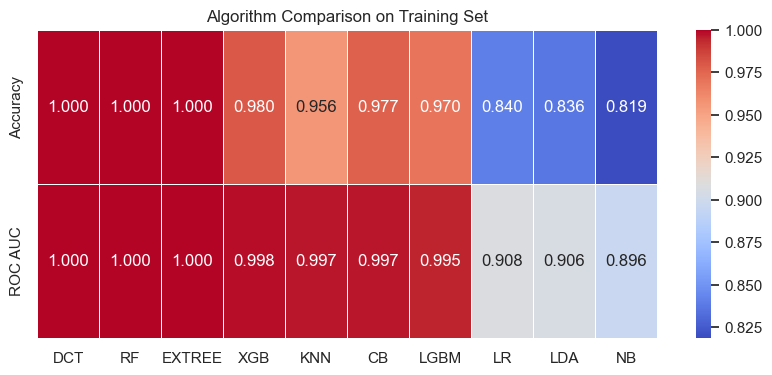

C:\Users\monas\AppData\Local\Temp\ipykernel_24148\2997277415.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=training_results_df.index, y=training_results_df["ROC AUC"], palette="coolwarm", edgecolor="black")


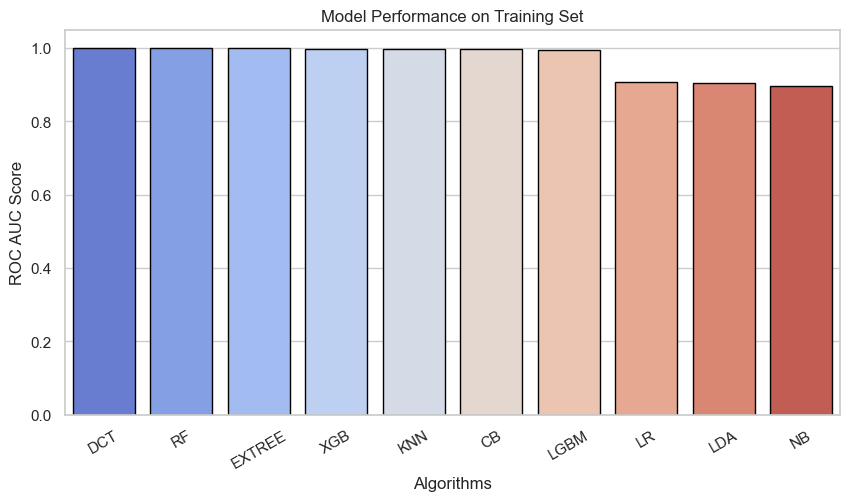

In [220]:
# --- 5. TRAINING Results Visualization ---
# Heatmap for Validation Set
plt.figure(figsize=(10, 4))
sns.heatmap(training_results_df.T, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title("Algorithm Comparison on Training Set")
plt.show()

# Bar Chart for Validation Set
plt.figure(figsize=(10, 5))
sns.barplot(x=training_results_df.index, y=training_results_df["ROC AUC"], palette="coolwarm", edgecolor="black")
plt.xticks(rotation=30)
plt.xlabel("Algorithms")
plt.ylabel("ROC AUC Score")
plt.title("Model Performance on Training Set")
plt.show()

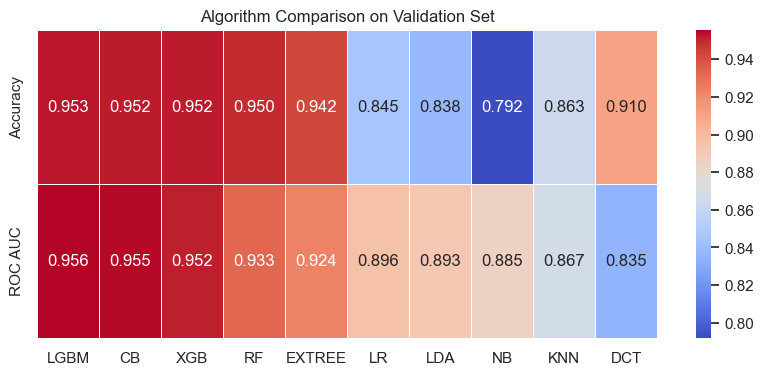

C:\Users\monas\AppData\Local\Temp\ipykernel_24148\103637727.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=validation_results_df.index, y=validation_results_df["ROC AUC"], palette="coolwarm", edgecolor="black")


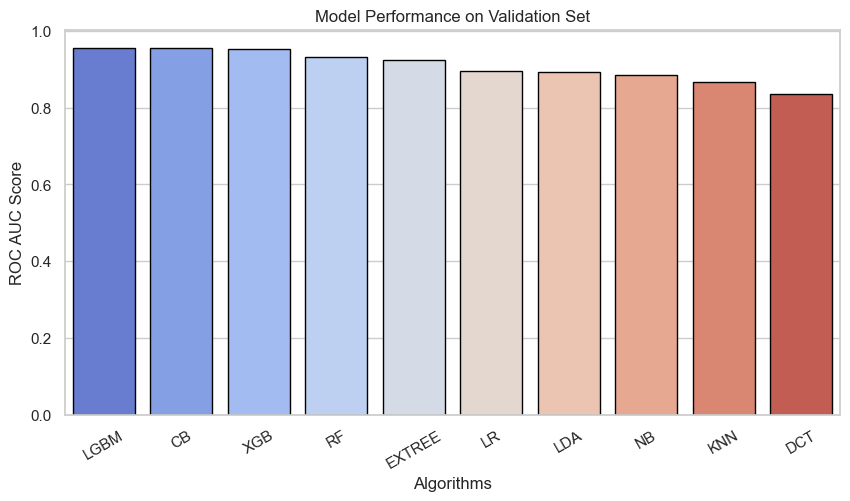

In [221]:
# --- 5. VALIDATION Results Visualization ---
# Heatmap for Validation Set
plt.figure(figsize=(10, 4))
sns.heatmap(validation_results_df.T, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title("Algorithm Comparison on Validation Set")
plt.show()

# Bar Chart for Validation Set
plt.figure(figsize=(10, 5))
sns.barplot(x=validation_results_df.index, y=validation_results_df["ROC AUC"], palette="coolwarm", edgecolor="black")
plt.xticks(rotation=30)
plt.xlabel("Algorithms")
plt.ylabel("ROC AUC Score")
plt.title("Model Performance on Validation Set")
plt.show()

        Mean AUC   Std AUC  Validation AUC
EXTREE  0.995378  0.000464        0.923632
CB      0.992464  0.000493        0.954566
RF      0.992332  0.000830        0.933071
XGB     0.992309  0.000494        0.951656
LGBM    0.991777  0.000448        0.955674
KNN     0.975386  0.000738        0.867168
DCT     0.943943  0.001043        0.835445
LR      0.907695  0.000821        0.895572
LDA     0.905400  0.000845        0.892771
NB      0.896317  0.001218        0.885324


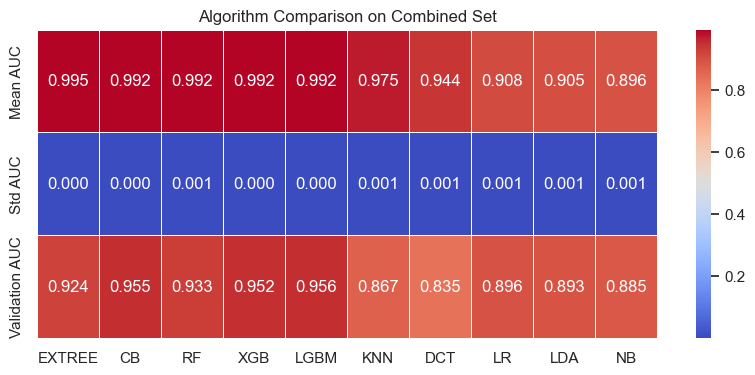

In [222]:
combined_results_df = pd.DataFrame(combined_results) #.T.sort_values(by="ROC AUC", ascending=False)
print(combined_results_df)

# --- 5. cOMBINED Results Visualization ---
# Heatmap for Validation Set
plt.figure(figsize=(10, 4))
sns.heatmap(combined_results_df.T, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title("Algorithm Comparison on Combined Set")
plt.show()

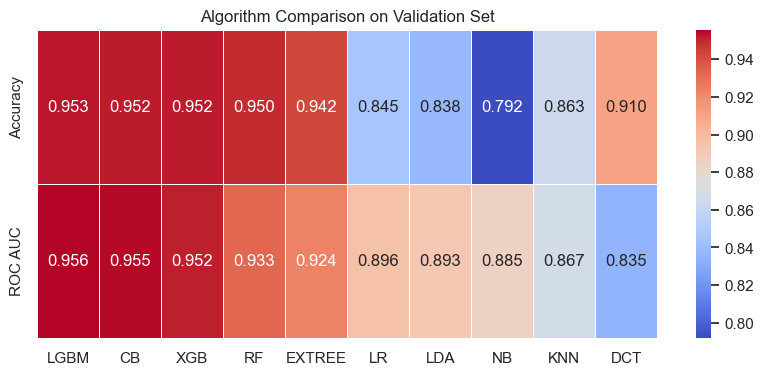

C:\Users\monas\AppData\Local\Temp\ipykernel_24148\103637727.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=validation_results_df.index, y=validation_results_df["ROC AUC"], palette="coolwarm", edgecolor="black")


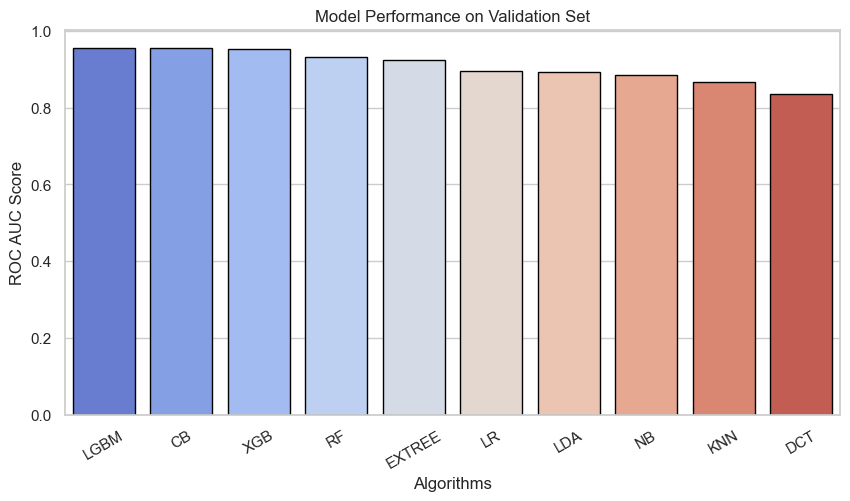

In [223]:
# --- 5. VALIDATION Results Visualization ---
# Heatmap for Validation Set
plt.figure(figsize=(10, 4))
sns.heatmap(validation_results_df.T, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title("Algorithm Comparison on Validation Set")
plt.show()

# Bar Chart for Validation Set
plt.figure(figsize=(10, 5))
sns.barplot(x=validation_results_df.index, y=validation_results_df["ROC AUC"], palette="coolwarm", edgecolor="black")
plt.xticks(rotation=30)
plt.xlabel("Algorithms")
plt.ylabel("ROC AUC Score")
plt.title("Model Performance on Validation Set")
plt.show()

In [236]:
y_test_pred_proba = best_lgbm.predict_proba(X_test_encoded)[:, 1]
# Prepare the submission file
submission_df = pd.DataFrame({'id': X_test_encoded.index, 'loan_status': y_test_pred_proba})
submission_file_path = 'loan_approval_submission_Mona_Final_2.csv'
submission_df.to_csv(submission_file_path, index=False)
print("Submission file saved successfully!")

Submission file saved successfully!
